In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
import os
import numpy as np
np.set_printoptions(linewidth=np.inf)

from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from random import shuffle

import pandas as pd

import pickle

from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier,ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing

#from scipy.misc import imread, imresize

%matplotlib inline

In [3]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [4]:
ALL_DATA_DIR = '/home/HDD6TB/datasets/emotions/'
INPUT_SIZE = (224, 224)
#INPUT_SIZE = (299, 299)

---

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Model,Sequential, load_model,model_from_json
from tensorflow.keras.applications import mobilenet,mobilenet_v2,densenet,inception_resnet_v2,inception_v3,vgg16,resnet_v2,resnet
#from tensorflow.keras.applications import efficientnet as enet
import efficientnet.tfkeras as enet
#from tensorflow.keras.utils.generic_utils import CustomObjectScope
from tensorflow.keras.layers import Flatten, Dense, Dropout,GlobalAveragePooling2D,Activation, Conv2D, Reshape,DepthwiseConv2D,Input
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, Callback, CSVLogger, EarlyStopping
from tensorflow.keras.metrics import top_k_categorical_accuracy
import numpy as np
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.compat.v1.keras.backend import set_session 

INPUT_SIZE = (224, 224)

BATCH_SIZE=40 #512 #64 #32 #64

def save_model(model,filename):
    model.save_weights('weights.h5')
    model_json = model.to_json()
    with open("model.json", "w") as json_file:
        json_file.write(model_json)

    json_file = open('model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights('weights.h5')
    loaded_model.save(filename)

In [6]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess=tf.compat.v1.Session(config=config)
set_session(sess)

In [7]:
USE_EFFICIENT_NET=False

if USE_EFFICIENT_NET:
    #import efficientnet.keras as enet

    base_model = enet.EfficientNetB3(weights=None)
    #base_model.load_weights('/home/avsavchenko/distr/efficientnet/efficientnet-b3-weights.h5')

    INPUT_SIZE = base_model.input_shape[1]
    INPUT_SIZE=(INPUT_SIZE,INPUT_SIZE)
    net_description='affectnet_enet3'
    net_model=enet
    BATCH_SIZE=16
    print(INPUT_SIZE)
elif False:
    net_model=mobilenet
    net_description='mobilenet_v1'
    INPUT_SIZE = (224, 224)
    BATCH_SIZE=80
    base_model = mobilenet.MobileNet(input_shape=(INPUT_SIZE[0],INPUT_SIZE[1],3), include_top=True, weights='imagenet')
elif False:
    net_model=inception_v3
    net_description='inception_v3'
    INPUT_SIZE = (299, 299)
    BATCH_SIZE=32
    base_model = inception_v3.InceptionV3(input_shape=(INPUT_SIZE[0],INPUT_SIZE[1],3), include_top=True, weights='imagenet')
else:
    base_model=load_model('age_gender_tf2_224_deep-03-0.13-0.97.h5')
    base_model.summary()
    net_description='my_mobilenet_8'
    if False:
        net_model=vgg16
    else:
        def mobilenet_preprocess_input(x,**kwargs):
            x[..., 0] -= 103.939
            x[..., 1] -= 116.779
            x[..., 2] -= 123.68
            return x
        preprocessing_function=mobilenet_preprocess_input
        
    BATCH_SIZE=80
    INPUT_SIZE = (224, 224)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
____________________________________________________________________________________________

In [65]:
if False:
    #save_model(model,'mymobilenet_ft_sgd_model.h5')
    #save_model(model,'mymobilenet_7_ft_sgd_model.h5')
    save_model(model,'affectnet_orig_my_mobilenet_8_ft_60.575_model.h5')
else:
    #model=load_model('mymobilenet_7_ft_sgd_model.h5')
    model=load_model('affectnet_affectnet_enet3_ft.h5')
    #model=load_model('affectnet_inception_v3_ft.h5')#'my_mobilenet_new1_ft_sgd.h5')

In [89]:
net_model=enet#inception_v3#
preprocessing_function=net_model.preprocess_input
INPUT_SIZE = (300, 300) #(299, 299)

In [7]:
USE_PREPROCESSING=True
print(INPUT_SIZE)

(224, 224)


---

In [8]:
RAMAS_DATA_DIR=ALL_DATA_DIR+'RAMAS/'
RAMAS_ANOTATIONS=RAMAS_DATA_DIR+'Annotations_by_files/'
RAMAS_ANOTATIONS_EMOTIONS=RAMAS_DATA_DIR+'Annotations_by_emotions/'
RAMAS_VIDEOS=RAMAS_DATA_DIR+'Data/Video_close/'

In [9]:
emotions=['Angry','Sad','Disgusted','Happy','Scared','Surprised','Neutral']
emotion2annotation={emotion:pd.read_csv(os.path.join(RAMAS_ANOTATIONS_EMOTIONS,'data_'+emotion+'.csv')) for emotion in emotions}

def emotions_for_timeframe(emo2ann,t, num_agreed_annotators=1):
    return [emo for emo,df in emo2ann.items() if len(df[(df.Start<=t) & (df.End>t)])>=num_agreed_annotators]

In [10]:
t=10
emo2ann={emo:df[df.File=='10dec_D11_1'] for emo,df in emotion2annotation.items()}
if False:
    df=emo2ann['Angry'];df=df[(df.Start<=t) & (df.End>t)]
    print(len(df))
    df
else:
    for num_agreed_annotators in range(1,6):
        print(num_agreed_annotators,emotions_for_timeframe(emo2ann,t,num_agreed_annotators))

1 ['Sad', 'Scared', 'Neutral']
2 ['Neutral']
3 ['Neutral']
4 []
5 []


In [11]:
dateId2Actor={}
actors=pd.read_csv(os.path.join(RAMAS_DATA_DIR,'Docs/actors_descr.csv'))
for index, row in actors.iterrows():
    dateId2Actor[(row.Date[:2]+'dec',row.ID)]=row.Name
print(dateId2Actor)

actor2filenames={}
for f in os.listdir(RAMAS_VIDEOS):
    filename=f.replace('_Video.mov','')
    fields=filename.split('_')
    actor=dateId2Actor[(fields[0],int(fields[2]))]
    if actor not in actor2filenames:
        actor2filenames[actor]=[]
    actor2filenames[actor].append(filename)

print(len(actor2filenames))

{('10dec', 2): 'Rodion Tolokonnikov', ('10dec', 1): 'Kristina Alexandrova', ('14dec', 1): 'Vlad Vladimirov', ('14dec', 2): 'Alina Rusanova', ('15dec', 2): 'Alexandr Dudenkov', ('15dec', 1): 'Luba Schevchenko', ('16dec', 1): 'Vladimir Lisenko', ('16dec', 2): 'Katerina Kashina', ('19dec', 2): 'Rodion Tolokonnikov', ('19dec', 1): 'Kristina Alexandrova', ('22dec', 1): 'Ravil Nasretdinov', ('22dec', 2): 'Katja Leonova'}
10


In [12]:
#print(idx_to_class)
Ramas2AffectNet={'Angry':0,'Sad':5,'Disgusted':1,'Happy':3,'Scared':2,'Surprised':6,'Neutral':4}
print(Ramas2AffectNet)

AffectNet2Ramas={a:r for r,a in Ramas2AffectNet.items()}
print(AffectNet2Ramas)

{'Angry': 0, 'Sad': 5, 'Disgusted': 1, 'Happy': 3, 'Scared': 2, 'Surprised': 6, 'Neutral': 4}
{0: 'Angry', 5: 'Sad', 1: 'Disgusted', 3: 'Happy', 2: 'Scared', 6: 'Surprised', 4: 'Neutral'}


In [13]:
USE_RETINA_FACE=False
RAMAS_VIDEOS_FRAMES=RAMAS_DATA_DIR+'Data/Video_close_mtcnn_aligned_rgb/'

In [14]:
if False:
    USE_PREPROCESSING=True
    emotion_indices=np.array([0,2,3,4,5,6,7])# 1: 'Contempt'
    RAMAS_VIDEOS_FRAMES=RAMAS_DATA_DIR+'Data/Video_close_retinaface_aligned_rgb/'
else:
    emotion_indices=None #7 classes
    USE_PREPROCESSING=False

In [12]:
import sys
new_sys_dir = '/home/avsavchenko/src/multimodal-pdmi-2020/visual_data/facial_analysis/'
if not new_sys_dir in sys.path:
    sys.path.append(new_sys_dir)

USE_RETINA_FACE=False
RAMAS_VIDEOS_FRAMES=RAMAS_DATA_DIR+'Data/Video_close_mtcnn_aligned_rgb/'
from facial_analysis import FacialImageProcessing
imgProcessing=FacialImageProcessing(False)

/home/avsavchenko/src/multimodal-pdmi-2020/visual_data/facial_analysis/facial_analysis.py:437: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if method is 'Min':


['ethnicity_pred/Softmax']
Tensor("age_pred/Softmax:0", shape=(None, 100), dtype=float32) Tensor("gender_pred/Sigmoid:0", shape=(None, 1), dtype=float32) Tensor("ethnicity_pred/Softmax:0", shape=(None, 5), dtype=float32) Tensor("global_pooling/Mean:0", shape=(None, 1024), dtype=float32)
Tensor("input_1:0", shape=(None, 224, 224, 3), dtype=float32) 224 224


In [12]:
import sys
USE_RETINA_FACE=True
RAMAS_VIDEOS_FRAMES=RAMAS_DATA_DIR+'Data/Video_close_retinaface_aligned/'
if True:
    new_sys_dir = '/home/avsavchenko/src/racial_bias/'
    if not new_sys_dir in sys.path:
        sys.path.append(new_sys_dir)

    from retinaface import RetinaFace
    detector = RetinaFace(prefix=new_sys_dir+'model',network='net3l')

    def get_alignment_rgb(img): # feed cv2 image
        im_scale = detector.get_scale(img)
        faces, landmarks = detector.detect(img,scales=[im_scale],do_flip=False)
        #print(faces)
        bboxes=[]
        for face_id in range(len(faces)): 
            face = faces[face_id]
            box = face[0:4].astype(np.int)

            dx = (box[2] - box[0])//5
            dy = (box[3] - box[1])//7
            x1 = max(0, box[0] - dx)
            y1 = max(0, box[1] - dy)
            y2 = min(img.shape[0], box[3] + dy)
            x2 = min(img.shape[1], box[2] + dx)

            bboxes.append([x1,y1,x2,y2])
        return bboxes,landmarks

In [75]:
def get_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : array
        order: {'x1', 'y1', 'x2', 'y2'}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : array
        order: {'x1', 'y1', 'x2', 'y2'}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[1], bb2[1])
    x_right = min(bb1[2], bb2[2])
    y_bottom = min(bb1[3], bb2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
    bb2_area = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    return iou

#print(get_iou([10,10,20,20],[15,15,25,25]))

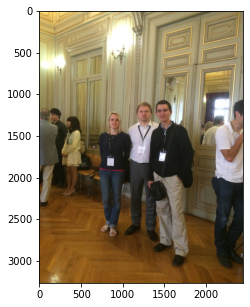

<Figure size 360x360 with 0 Axes>

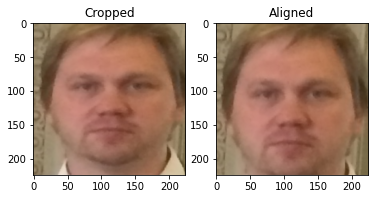

<Figure size 360x360 with 0 Axes>

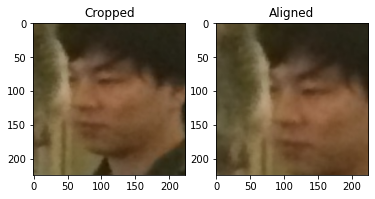

<Figure size 360x360 with 0 Axes>

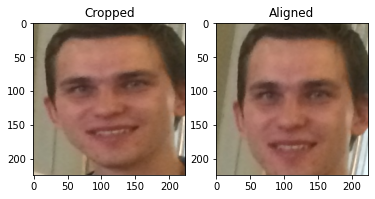

<Figure size 360x360 with 0 Axes>

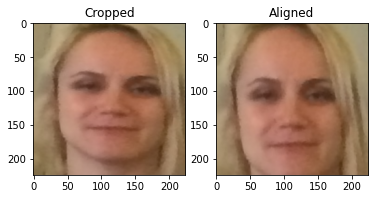

<Figure size 360x360 with 0 Axes>

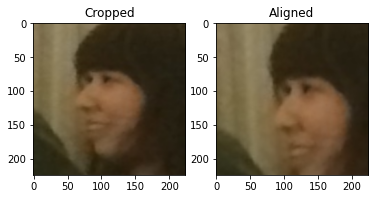

In [76]:
import numpy as np
import cv2
import math
from skimage import transform as trans
def preprocess(img, bbox=None, landmark=None, **kwargs):
    M = None
    image_size = [224,224]
    src = np.array([
      [30.2946, 51.6963],
      [65.5318, 51.5014],
      [48.0252, 71.7366],
      [33.5493, 92.3655],
      [62.7299, 92.2041] ], dtype=np.float32 )
    if image_size[1]==224:
        src[:,0] += 8.0
    src*=2
    if landmark is not None:
        dst = landmark.astype(np.float32)

        tform = trans.SimilarityTransform()
        #dst=dst[:3]
        #src=src[:3]
        #print(dst.shape,src.shape,dst,src)
        tform.estimate(dst, src)
        M = tform.params[0:2,:]
        #M = cv2.estimateRigidTransform( dst.reshape(1,5,2), src.reshape(1,5,2), False)
        #print(M)

    if M is None:
        if bbox is None: #use center crop
            det = np.zeros(4, dtype=np.int32)
            det[0] = int(img.shape[1]*0.0625)
            det[1] = int(img.shape[0]*0.0625)
            det[2] = img.shape[1] - det[0]
            det[3] = img.shape[0] - det[1]
        else:
              det = bbox
        margin = kwargs.get('margin', 44)
        bb = np.zeros(4, dtype=np.int32)
        bb[0] = np.maximum(det[0]-margin//2, 0)
        bb[1] = np.maximum(det[1]-margin//2, 0)
        bb[2] = np.minimum(det[2]+margin//2, img.shape[1])
        bb[3] = np.minimum(det[3]+margin//2, img.shape[0])
        ret = img[bb[1]:bb[3],bb[0]:bb[2],:]
        if len(image_size)>0:
              ret = cv2.resize(ret, (image_size[1], image_size[0]))
        return ret 
    else: #do align using landmark
        assert len(image_size)==2
        warped = cv2.warpAffine(img,M,(image_size[1],image_size[0]), borderValue = 0.0)
        return warped

def list2colmatrix(pts_list):
    """
        convert list to column matrix
    Parameters:
    ----------
        pts_list:
            input list
    Retures:
    -------
        colMat: 

    """
    assert len(pts_list) > 0
    colMat = []
    for i in range(len(pts_list)):
        colMat.append(pts_list[i][0])
        colMat.append(pts_list[i][1])
    colMat = np.matrix(colMat).transpose()
    return colMat  

def find_tfrom_between_shapes(from_shape, to_shape):
    """
        find transform between shapes
    Parameters:
    ----------
        from_shape: 
        to_shape: 
    Retures:
    -------
        tran_m:
        tran_b:
    """
    assert from_shape.shape[0] == to_shape.shape[0] and from_shape.shape[0] % 2 == 0

    sigma_from = 0.0
    sigma_to = 0.0
    cov = np.matrix([[0.0, 0.0], [0.0, 0.0]])

    # compute the mean and cov
    from_shape_points = from_shape.reshape(from_shape.shape[0]//2, 2)
    to_shape_points = to_shape.reshape(to_shape.shape[0]//2, 2)
    mean_from = from_shape_points.mean(axis=0)
    mean_to = to_shape_points.mean(axis=0)

    for i in range(from_shape_points.shape[0]):
        temp_dis = np.linalg.norm(from_shape_points[i] - mean_from)
        sigma_from += temp_dis * temp_dis
        temp_dis = np.linalg.norm(to_shape_points[i] - mean_to)
        sigma_to += temp_dis * temp_dis
        cov += (to_shape_points[i].transpose() - mean_to.transpose()) * (from_shape_points[i] - mean_from)

    sigma_from = sigma_from / to_shape_points.shape[0]
    sigma_to = sigma_to / to_shape_points.shape[0]
    cov = cov / to_shape_points.shape[0]

    # compute the affine matrix
    s = np.matrix([[1.0, 0.0], [0.0, 1.0]])
    u, d, vt = np.linalg.svd(cov)

    if np.linalg.det(cov) < 0:
        if d[1] < d[0]:
            s[1, 1] = -1
        else:
            s[0, 0] = -1
    r = u * s * vt
    c = 1.0
    if sigma_from != 0:
        c = 1.0 / sigma_from * np.trace(np.diag(d) * s)

    tran_b = mean_to.transpose() - c * r * mean_from.transpose()
    tran_m = c * r

    return tran_m, tran_b

def extract_image_chip(img, p, desired_size=256, padding=0):
    crop_imgs = []
    shape  =[]
    for k in range(len(p)//2):
        shape.append(p[k])
        shape.append(p[k+5])

    if padding > 0:
        padding = padding
    else:
        padding = 0
    # average positions of face points
    mean_face_shape_x = [0.224152, 0.75610125, 0.490127, 0.254149, 0.726104]
    mean_face_shape_y = [0.2119465, 0.2119465, 0.628106, 0.780233, 0.780233]

    from_points = []
    to_points = []

    for i in range(len(shape)//2):
        x = (padding + mean_face_shape_x[i]) / (2 * padding + 1) * desired_size
        y = (padding + mean_face_shape_y[i]) / (2 * padding + 1) * desired_size
        to_points.append([x, y])
        from_points.append([shape[2*i], shape[2*i+1]])

    # convert the points to Mat
    from_mat = list2colmatrix(from_points)
    to_mat = list2colmatrix(to_points)

    # compute the similar transfrom
    tran_m, tran_b = find_tfrom_between_shapes(from_mat, to_mat)

    probe_vec = np.matrix([1.0, 0.0]).transpose()
    probe_vec = tran_m * probe_vec

    scale = np.linalg.norm(probe_vec)
    angle = 180.0 / math.pi * math.atan2(probe_vec[1, 0], probe_vec[0, 0])

    from_center = [(shape[0]+shape[2])/2.0, (shape[1]+shape[3])/2.0]
    to_center = [0, 0]
    to_center[1] = desired_size * 0.4
    to_center[0] = desired_size * 0.5

    ex = to_center[0] - from_center[0]
    ey = to_center[1] - from_center[1]

    rot_mat = cv2.getRotationMatrix2D((from_center[0], from_center[1]), -1*angle, scale)
    rot_mat[0][2] += ex
    rot_mat[1][2] += ey

    chips = cv2.warpAffine(img, rot_mat, (desired_size, desired_size))

    return chips

fpath='/home/avsavchenko/images/IMG_0152.JPG' #0152 1636 1819
#fpath='/home/avsavchenko/images/173962.png'
frame_bgr=cv2.imread(fpath)
plt.figure(figsize=(5, 5))
frame = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(frame)
if USE_RETINA_FACE:
    im_scale = detector.get_scale(frame)
    bounding_boxes, points = detector.detect(frame,scales=[im_scale],do_flip=False)
else:
    bounding_boxes, points = imgProcessing.detect_faces(frame)
    points = points.T
for bbox,p in zip(bounding_boxes, points):
    box = bbox.astype(np.int)
    x1,y1,x2,y2=box[0:4]    
    #face_img=frame[y1:y2,x1:x2,:]

    #face_img=extract_image_chip(frame,p)
    if not USE_RETINA_FACE:
        p = p.reshape((2,5)).T
        
    plt.figure(figsize=(5, 5))
    fig, (ax1, ax2) = plt.subplots(1, 2)
    face_img=preprocess(frame,box,None) #p)
    ax1.set_title('Cropped')
    ax1.imshow(face_img)
    
    face_img=preprocess(frame,box,p)
    ax2.set_title('Aligned')
    ax2.imshow(face_img)

## Feature extraction by frame 

### Face detection 

In [18]:
#Face detection
print(RAMAS_VIDEOS_FRAMES)
n_frames=1
for filename in log_progress(os.listdir(RAMAS_VIDEOS)[:]):
    print(filename)
    fn=filename.replace('_Video.mov','')
    
    video_path=os.path.join(RAMAS_VIDEOS,filename)
    face_out_path=os.path.join(RAMAS_VIDEOS_FRAMES,filename)
    if not os.path.exists(face_out_path):
        os.makedirs(face_out_path)
    
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    X_scores,y_classes=[],[]
    prev_b=None
    counter=0
    
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))//n_frames
    for frame_count in range(n_frames,n_frames*(total_frames+1),n_frames):
        cap.set(cv2.CAP_PROP_POS_FRAMES,frame_count)
        ret, frame_bgr = cap.read()
        if not ret:
            cap.release()
            break
        frame = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
        if USE_RETINA_FACE:
            im_scale = detector.get_scale(frame)
            bounding_boxes, points = detector.detect(frame,scales=[im_scale],do_flip=False)
        else:
            bounding_boxes, points = imgProcessing.detect_faces(frame)
            points = points.T

        best_ind=None
        if len(bounding_boxes)==0:
            print('No faces found for ',filename)
            counter+=1
            if prev_b is None or counter>3:
                continue
            else:
                b=prev_b
        elif len(bounding_boxes)>1:
            print('Too many faces (',len(bounding_boxes),') found for ',filename)
            if prev_b is None:
                continue
            else:
                best_iou=0
                for i in range(len(bounding_boxes)):
                    iou=get_iou(bounding_boxes[i],prev_b)
                    if iou>best_iou:
                        best_iou=iou
                        best_ind=i
                if best_iou>0:
                    b=[int(bi) for bi in bounding_boxes[best_ind]]
                    print('best_iou (',best_iou,') best_bb ',bounding_boxes[best_ind])
                else:
                    continue
        else:
            best_ind=0
            b=[int(bi) for bi in bounding_boxes[best_ind]]
            counter=0
        prev_b=b

        if True:
            p=None
            if best_ind is not None:
                p=points[best_ind]
                if not USE_RETINA_FACE:
                    p = p.reshape((2,5)).T
            face_img=preprocess(frame,b,p)
        else:
            x1,y1,x2,y2=b[0:4]
            face_img=frame[y1:y2,x1:x2,:]
        if np.prod(face_img.shape)==0:
            print('Empty face ',b,' found for ',filename)
            continue

        cv2.imwrite(os.path.join(face_out_path,'{:05d}.jpg'.format(frame_count)),cv2.cvtColor(face_img, cv2.COLOR_RGB2BGR))

/home/HDD6TB/datasets/emotions/RAMAS/Data/Video_close_mtcnn_aligned_rgb/


In [34]:
base_model=load_model('mymobilenet_7_ft_sgd_model.h5')
base_model.summary()
print(INPUT_SIZE)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128 

In [35]:
COMPUTE_FEATURES=True
if COMPUTE_FEATURES:
    #base_model=model
    featureModel=Model(base_model.inputs, [base_model.output,base_model.layers[-4].output])
    featureModel.summary()
    model=featureModel

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128   

In [67]:
#model.load_weights(net_description+'_ft.h5')
print(RAMAS_VIDEOS_FRAMES)
filename2x_scores,filename2y_classes={},{}
if COMPUTE_FEATURES:
    filename2x_features={}
for filename in log_progress(os.listdir(RAMAS_VIDEOS)[:]):
    #print(filename)
    fn=filename.replace('_Video.mov','')
    emo2ann={emo:df[df.File==fn].drop(columns=['ID','File']) for emo,df in emotion2annotation.items()}

    video_path=os.path.join(RAMAS_VIDEOS,filename)
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    face_out_path=os.path.join(RAMAS_VIDEOS_FRAMES,filename)
    X_scores,X_features,y_classes=[],[],[]
    imgs=[]
    for frame_file in sorted(os.listdir(face_out_path))[:]:
        frame_bgr = cv2.imread(os.path.join(face_out_path,frame_file))
        if False:
            face_img = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
        else:
            face_img = frame_bgr
        face_img=cv2.resize(face_img,INPUT_SIZE)
        imgs.append(face_img)
        if len(imgs)>=512:        
            if USE_PREPROCESSING:
                inp = preprocessing_function(np.array(imgs, dtype=np.float32))
            else:
                inp = np.array(imgs, dtype=np.float32)
                inp[..., 0] -= 103.939
                inp[..., 1] -= 116.779
                inp[..., 2] -= 123.68
            
            scores=model.predict(inp)
            if COMPUTE_FEATURES:
                #print(scores[0].shape,scores[1].shape)
                if len(X_scores)==0:
                    X_scores=scores[0]
                    X_features=scores[1]
                else:
                    X_scores=np.concatenate((X_scores,scores[0]),axis=0)
                    X_features=np.concatenate((X_features,scores[1]),axis=0)
            else:
                if len(X_scores)==0:
                    X_scores=scores
                else:
                    X_scores=np.concatenate((X_scores,scores),axis=0)
            
            imgs=[]
        
        frame_count=int(frame_file.replace('.jpg',''))
        t = float(frame_count)/fps
        y_classes.append(emotions_for_timeframe(emo2ann,t))

    if len(imgs)>0:        
        if USE_PREPROCESSING:
            inp = preprocessing_function(np.array(imgs, dtype=np.float32))
        else:
            inp = np.array(imgs, dtype=np.float32)
            inp[..., 0] -= 103.939
            inp[..., 1] -= 116.779
            inp[..., 2] -= 123.68

        scores=model.predict(inp)
        if COMPUTE_FEATURES:
            #print(scores[0].shape,scores[1].shape)
            if len(X_scores)==0:
                X_scores=scores[0]
                X_features=scores[1]
            else:
                X_scores=np.concatenate((X_scores,scores[0]),axis=0)
                X_features=np.concatenate((X_features,scores[1]),axis=0)
        else:
            if len(X_scores)==0:
                X_scores=scores
            else:
                X_scores=np.concatenate((X_scores,scores),axis=0)

    print(filename,X_scores.shape,len(y_classes))
    filename2x_scores[filename]=X_scores
    filename2y_classes[filename]=y_classes
    if COMPUTE_FEATURES:
        print(X_features.shape)
        filename2x_features[filename]=X_features

/home/HDD6TB/datasets/emotions/RAMAS/Data/Video_close_mtcnn_aligned_rgb/


15dec_K14_1_Video.mov (1156, 7) 1156
(1156, 1024)
22dec_D43_2_Video.mov (3681, 7) 3681
(3681, 1024)
10dec_D42_1_Video.mov (1471, 7) 1471
(1471, 1024)
14dec_D51_2_Video.mov (2019, 7) 2019
(2019, 1024)
22dec_K44_1_Video.mov (4566, 7) 4566
(4566, 1024)
14dec_N25_2_Video.mov (1991, 7) 1991
(1991, 1024)
19dec_D53_2_Video.mov (1755, 7) 1755
(1755, 1024)
14dec_K45_1_Video.mov (2208, 7) 2208
(2208, 1024)
15dec_D53_1_Video.mov (1917, 7) 1917
(1917, 1024)
14dec_N23_1_Video.mov (2555, 7) 2555
(2555, 1024)
19dec_N12_2_Video.mov (7735, 7) 7735
(7735, 1024)
10dec_N11_2_Video.mov (35294, 7) 35294
(35294, 1024)
16dec_K23_1_Video.mov (2533, 7) 2533
(2533, 1024)
22dec_D21_1_Video.mov (2501, 7) 2501
(2501, 1024)
14dec_K61_2_Video.mov (1815, 7) 1815
(1815, 1024)
15dec_K31_2_Video.mov (2338, 7) 2338
(2338, 1024)
22dec_K31_1_Video.mov (2322, 7) 2322
(2322, 1024)
22dec_K24_1_Video.mov (3166, 7) 3166
(3166, 1024)
19dec_D23_1_Video.mov (2621, 7) 2621
(2621, 1024)
16dec_K62_2_Video.mov (1192, 7) 1192
(1192, 102

14dec_K54_1_Video.mov (1752, 7) 1752
(1752, 1024)
22dec_D72_2_Video.mov (2271, 7) 2271
(2271, 1024)
19dec_K53_2_Video.mov (3918, 7) 3918
(3918, 1024)
14dec_K33_2_Video.mov (5045, 7) 5045
(5045, 1024)
10dec_D64_2_Video.mov (1806, 7) 1806
(1806, 1024)
16dec_O11_1_Video.mov (1828, 7) 1828
(1828, 1024)
14dec_D12_1_Video.mov (2002, 7) 2002
(2002, 1024)
14dec_D65_2_Video.mov (2010, 7) 2010
(2010, 1024)
10dec_D62_1_Video.mov (1561, 7) 1561
(1561, 1024)
15dec_D12_1_Video.mov (3374, 7) 3374
(3374, 1024)
14dec_N26_1_Video.mov (2211, 7) 2211
(2211, 1024)
15dec_K34_2_Video.mov (2644, 7) 2644
(2644, 1024)
22dec_K45_2_Video.mov (3177, 7) 3177
(3177, 1024)
22dec_D22_2_Video.mov (2360, 7) 2360
(2360, 1024)
19dec_D52_1_Video.mov (2242, 7) 2242
(2242, 1024)
19dec_D31_1_Video.mov (2755, 7) 2755
(2755, 1024)
15dec_D11_2_Video.mov (3224, 7) 3224
(3224, 1024)
15dec_N11_1_Video.mov (10620, 7) 10620
(10620, 1024)
10dec_K71_1_Video.mov (1683, 7) 1683
(1683, 1024)
14dec_K21_1_Video.mov (1834, 7) 1834
(1834, 102

16dec_K21_1_Video.mov (2252, 7) 2252
(2252, 1024)
16dec_D42_2_Video.mov (2022, 7) 2022
(2022, 1024)
16dec_K63_2_Video.mov (2365, 7) 2365
(2365, 1024)
22dec_K31_2_Video.mov (2284, 7) 2284
(2284, 1024)
10dec_D71_2_Video.mov (1493, 7) 1493
(1493, 1024)
19dec_K52_2_Video.mov (1579, 7) 1579
(1579, 1024)
19dec_K42_1_Video.mov (2220, 7) 2220
(2220, 1024)
16dec_D23_1_Video.mov (2377, 7) 2377
(2377, 1024)
22dec_K23_1_Video.mov (4160, 7) 4160
(4160, 1024)
22dec_D71_2_Video.mov (2574, 7) 2574
(2574, 1024)
10dec_D11_1_Video.mov (17402, 7) 17402
(17402, 1024)
15dec_K21_1_Video.mov (1527, 7) 1527
(1527, 1024)
15dec_D63_2_Video.mov (2848, 7) 2848
(2848, 1024)
19dec_K12_2_Video.mov (2096, 7) 2096
(2096, 1024)
22dec_D53_1_Video.mov (3102, 7) 3102
(3102, 1024)
16dec_D64_2_Video.mov (1897, 7) 1897
(1897, 1024)
16dec_D13_1_Video.mov (2216, 7) 2216
(2216, 1024)
14dec_D41_2_Video.mov (2511, 7) 2511
(2511, 1024)
22dec_D64_2_Video.mov (3001, 7) 3001
(3001, 1024)
15dec_K32_1_Video.mov (1404, 7) 1404
(1404, 102

16dec_N13_1_Video.mov (9752, 7) 9752
(9752, 1024)
22dec_N16_2_Video.mov (5717, 7) 5717
(5717, 1024)
14dec_D32_1_Video.mov (2279, 7) 2279
(2279, 1024)
15dec_K62_1_Video.mov (1172, 7) 1172
(1172, 1024)
14dec_N26_2_Video.mov (2211, 7) 2211
(2211, 1024)
10dec_K42_1_Video.mov (1523, 7) 1523
(1523, 1024)
15dec_D73_1_Video.mov (894, 7) 894
(894, 1024)
22dec_K24_2_Video.mov (3157, 7) 3157
(3157, 1024)
15dec_D52_2_Video.mov (3921, 7) 3921
(3921, 1024)
19dec_K23_1_Video.mov (1925, 7) 1925
(1925, 1024)
19dec_D61_1_Video.mov (2676, 7) 2676
(2676, 1024)
16dec_K64_1_Video.mov (1942, 7) 1942
(1942, 1024)
22dec_D43_1_Video.mov (3542, 7) 3542
(3542, 1024)
16dec_O12_1_Video.mov (1612, 7) 1612
(1612, 1024)
14dec_D11_2_Video.mov (1824, 7) 1824
(1824, 1024)
14dec_D43_2_Video.mov (2716, 7) 2716
(2716, 1024)
10dec_D41_1_Video.mov (1580, 7) 1580
(1580, 1024)
14dec_N21_1_Video.mov (2497, 7) 2497
(2497, 1024)
19dec_D62_1_Video.mov (2720, 7) 2720
(2720, 1024)
19dec_K44_1_Video.mov (2221, 7) 2221
(2221, 1024)
10d

### PyTorch 

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from torchvision import datasets, transforms

device='cuda'

In [25]:
PATH='affectnet_7_vggface2_enet0_new.pt'
model=torch.load(PATH)
model=model.to(device)
model.eval()

EfficientNet(
  (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
    )
    (1): Sequential(
      (0

In [26]:
last_layer=torch.nn.Sequential(model.classifier[0],torch.nn.Softmax(dim=1))
if True:
    inp = torch.randn(20, 1280).to(device)
    f=last_layer.forward(inp)
    print(f.shape,f,f.sum(axis=1))
model.classifier=torch.nn.Identity()

torch.Size([20, 7]) tensor([[1.4607e-01, 6.6691e-01, 1.6397e-03, 2.3204e-04, 1.3092e-01, 2.4519e-03,
         5.1769e-02],
        [6.7444e-01, 3.0913e-01, 5.5106e-05, 3.5128e-05, 1.5591e-02, 6.4745e-05,
         6.8083e-04],
        [4.3736e-06, 2.2540e-04, 9.9703e-01, 1.6358e-07, 5.4692e-04, 1.3745e-05,
         2.1782e-03],
        [9.0503e-03, 3.0090e-01, 2.1635e-03, 2.0113e-03, 5.5589e-01, 1.2984e-01,
         1.4169e-04],
        [8.6397e-05, 2.9099e-03, 9.6299e-01, 4.2802e-07, 3.5314e-03, 3.0465e-02,
         1.5793e-05],
        [8.0602e-03, 6.5683e-04, 6.4879e-02, 7.9117e-03, 8.4794e-01, 1.0525e-02,
         6.0025e-02],
        [9.3850e-03, 6.6866e-04, 1.3173e-03, 9.4059e-01, 4.6937e-02, 5.2845e-04,
         5.7640e-04],
        [3.6595e-03, 4.9415e-07, 2.1948e-05, 1.2025e-04, 9.9391e-01, 4.4253e-04,
         1.8443e-03],
        [9.8301e-01, 9.1916e-04, 1.2003e-02, 1.9104e-05, 2.8422e-06, 2.3545e-03,
         1.6890e-03],
        [9.3111e-03, 3.2599e-01, 5.6427e-03, 8.5196e-

In [16]:
test_transforms = transforms.Compose(
    [
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    ]
)

In [31]:
COMPUTE_FEATURES=True
print(RAMAS_VIDEOS_FRAMES)
filename2x_scores,filename2y_classes={},{}
if COMPUTE_FEATURES:
    filename2x_features={}
for filename in log_progress(os.listdir(RAMAS_VIDEOS)[:]):
    #print(filename)
    fn=filename.replace('_Video.mov','')
    emo2ann={emo:df[df.File==fn].drop(columns=['ID','File']) for emo,df in emotion2annotation.items()}

    video_path=os.path.join(RAMAS_VIDEOS,filename)
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    face_out_path=os.path.join(RAMAS_VIDEOS_FRAMES,filename)
    X_scores,X_features,y_classes=[],[],[]
    imgs=[]
    for frame_file in sorted(os.listdir(face_out_path))[:]:
        img = Image.open(os.path.join(face_out_path,frame_file))
        img_tensor = test_transforms(img)
        imgs.append(img_tensor)
        if len(imgs)>=64:        
            features = model(torch.stack(imgs, dim=0).to(device))
            scores=last_layer(features)
            features=features.data.cpu().numpy()
            scores=scores.data.cpu().numpy()
            #print(features.shape,scores.shape)
            if COMPUTE_FEATURES:
                #print(scores[0].shape,scores[1].shape)
                if len(X_scores)==0:
                    X_scores=scores
                    X_features=features
                else:
                    X_scores=np.concatenate((X_scores,scores),axis=0)
                    X_features=np.concatenate((X_features,features),axis=0)
            else:
                if len(X_scores)==0:
                    X_scores=scores
                else:
                    X_scores=np.concatenate((X_scores,scores),axis=0)
            
            imgs=[]
        
        frame_count=int(frame_file.replace('.jpg',''))
        t = float(frame_count)/fps
        y_classes.append(emotions_for_timeframe(emo2ann,t))

    if len(imgs)>0:        
        features = model(torch.stack(imgs, dim=0).to(device))
        scores=last_layer(features)
        features=features.data.cpu().numpy()
        scores=scores.data.cpu().numpy()
        print(features.shape,scores.shape)
        if COMPUTE_FEATURES:
            #print(scores[0].shape,scores[1].shape)
            if len(X_scores)==0:
                X_scores=scores
                X_features=features
            else:
                X_scores=np.concatenate((X_scores,scores),axis=0)
                X_features=np.concatenate((X_features,features),axis=0)
        else:
            if len(X_scores)==0:
                X_scores=scores
            else:
                X_scores=np.concatenate((X_scores,scores),axis=0)

    print(filename,X_scores.shape,len(y_classes))
    filename2x_scores[filename]=X_scores
    filename2y_classes[filename]=y_classes
    if COMPUTE_FEATURES:
        print(X_features.shape)
        filename2x_features[filename]=X_features

/home/HDD6TB/datasets/emotions/RAMAS/Data/Video_close_mtcnn_aligned_rgb/


(4, 1280) (4, 7)
15dec_K14_1_Video.mov (1156, 7) 1156
(1156, 1280)
(33, 1280) (33, 7)
22dec_D43_2_Video.mov (3681, 7) 3681
(3681, 1280)
(63, 1280) (63, 7)
10dec_D42_1_Video.mov (1471, 7) 1471
(1471, 1280)
(35, 1280) (35, 7)
14dec_D51_2_Video.mov (2019, 7) 2019
(2019, 1280)
(22, 1280) (22, 7)
22dec_K44_1_Video.mov (4566, 7) 4566
(4566, 1280)
(7, 1280) (7, 7)
14dec_N25_2_Video.mov (1991, 7) 1991
(1991, 1280)
(27, 1280) (27, 7)
19dec_D53_2_Video.mov (1755, 7) 1755
(1755, 1280)
(32, 1280) (32, 7)
14dec_K45_1_Video.mov (2208, 7) 2208
(2208, 1280)
(61, 1280) (61, 7)
15dec_D53_1_Video.mov (1917, 7) 1917
(1917, 1280)
(59, 1280) (59, 7)
14dec_N23_1_Video.mov (2555, 7) 2555
(2555, 1280)
(55, 1280) (55, 7)
19dec_N12_2_Video.mov (7735, 7) 7735
(7735, 1280)
(30, 1280) (30, 7)
10dec_N11_2_Video.mov (35294, 7) 35294
(35294, 1280)
(37, 1280) (37, 7)
16dec_K23_1_Video.mov (2533, 7) 2533
(2533, 1280)
(5, 1280) (5, 7)
22dec_D21_1_Video.mov (2501, 7) 2501
(2501, 1280)
(23, 1280) (23, 7)
14dec_K61_2_Video.

(56, 1280) (56, 7)
19dec_D62_2_Video.mov (2744, 7) 2744
(2744, 1280)
(60, 1280) (60, 7)
16dec_D43_1_Video.mov (1788, 7) 1788
(1788, 1280)
(28, 1280) (28, 7)
14dec_D43_1_Video.mov (2716, 7) 2716
(2716, 1280)
(40, 1280) (40, 7)
16dec_D52_1_Video.mov (2152, 7) 2152
(2152, 1280)
(27, 1280) (27, 7)
16dec_D43_2_Video.mov (1691, 7) 1691
(1691, 1280)
(8, 1280) (8, 7)
10dec_K61_1_Video.mov (1544, 7) 1544
(1544, 1280)
(15, 1280) (15, 7)
16dec_N11_2_Video.mov (2319, 7) 2319
(2319, 1280)
(48, 1280) (48, 7)
10dec_K52_2_Video.mov (688, 7) 688
(688, 1280)
(57, 1280) (57, 7)
19dec_K43_2_Video.mov (2297, 7) 2297
(2297, 1280)
(24, 1280) (24, 7)
19dec_D61_2_Video.mov (2712, 7) 2712
(2712, 1280)
(45, 1280) (45, 7)
22dec_K53_1_Video.mov (2541, 7) 2541
(2541, 1280)
(53, 1280) (53, 7)
14dec_K33_1_Video.mov (5045, 7) 5045
(5045, 1280)
(12, 1280) (12, 7)
19dec_D63_1_Video.mov (2316, 7) 2316
(2316, 1280)
(53, 1280) (53, 7)
16dec_K22_2_Video.mov (1717, 7) 1717
(1717, 1280)
(12, 1280) (12, 7)
16dec_K46_1_Video.mo

(7, 1280) (7, 7)
14dec_N25_1_Video.mov (1991, 7) 1991
(1991, 1280)
(53, 1280) (53, 7)
15dec_D31_1_Video.mov (3509, 7) 3509
(3509, 1280)
(16, 1280) (16, 7)
15dec_K63_2_Video.mov (2512, 7) 2512
(2512, 1280)
(27, 1280) (27, 7)
15dec_K33_2_Video.mov (2267, 7) 2267
(2267, 1280)
(43, 1280) (43, 7)
14dec_D53_1_Video.mov (4459, 7) 4459
(4459, 1280)
(21, 1280) (21, 7)
16dec_K64_2_Video.mov (1941, 7) 1941
(1941, 1280)
(29, 1280) (29, 7)
15dec_K61_1_Video.mov (1309, 7) 1309
(1309, 1280)
(20, 1280) (20, 7)
22dec_N14_2_Video.mov (6292, 7) 6292
(6292, 1280)
(39, 1280) (39, 7)
22dec_K33_1_Video.mov (1895, 7) 1895
(1895, 1280)
(50, 1280) (50, 7)
19dec_D11_1_Video.mov (2162, 7) 2162
(2162, 1280)
(1, 1280) (1, 7)
14dec_K13_2_Video.mov (2561, 7) 2561
(2561, 1280)
(22, 1280) (22, 7)
14dec_K41_1_Video.mov (13846, 7) 13846
(13846, 1280)
(47, 1280) (47, 7)
15dec_D53_2_Video.mov (3823, 7) 3823
(3823, 1280)
(47, 1280) (47, 7)
15dec_D52_1_Video.mov (2159, 7) 2159
(2159, 1280)
(9, 1280) (9, 7)
15dec_D43_2_Video.

(3, 1280) (3, 7)
14dec_D72_1_Video.mov (1859, 7) 1859
(1859, 1280)
(7, 1280) (7, 7)
15dec_N21_2_Video.mov (3655, 7) 3655
(3655, 1280)
(36, 1280) (36, 7)
14dec_D42_1_Video.mov (2404, 7) 2404
(2404, 1280)
(48, 1280) (48, 7)
15dec_K32_2_Video.mov (2800, 7) 2800
(2800, 1280)
(12, 1280) (12, 7)
14dec_D52_2_Video.mov (4364, 7) 4364
(4364, 1280)
(18, 1280) (18, 7)
16dec_O21_1_Video.mov (4242, 7) 4242
(4242, 1280)
(56, 1280) (56, 7)
22dec_D13_1_Video.mov (2616, 7) 2616
(2616, 1280)
(25, 1280) (25, 7)
22dec_D42_1_Video.mov (2969, 7) 2969
(2969, 1280)
(61, 1280) (61, 7)
19dec_D23_2_Video.mov (2621, 7) 2621
(2621, 1280)
(34, 1280) (34, 7)
10dec_D43_1_Video.mov (1570, 7) 1570
(1570, 1280)
(8, 1280) (8, 7)
14dec_K32_1_Video.mov (1736, 7) 1736
(1736, 1280)
(27, 1280) (27, 7)
10dec_D31_2_Video.mov (1563, 7) 1563
(1563, 1280)
(57, 1280) (57, 7)
22dec_K11_1_Video.mov (2361, 7) 2361
(2361, 1280)
(54, 1280) (54, 7)
15dec_D41_1_Video.mov (7734, 7) 7734
(7734, 1280)
(2, 1280) (2, 7)
22dec_K14_1_Video.mov (

(6, 1280) (6, 7)
22dec_K61_2_Video.mov (2630, 7) 2630
(2630, 1280)
(60, 1280) (60, 7)
19dec_K51_2_Video.mov (2236, 7) 2236
(2236, 1280)
(17, 1280) (17, 7)
15dec_K52_1_Video.mov (1169, 7) 1169
(1169, 1280)
(54, 1280) (54, 7)
22dec_D62_1_Video.mov (2678, 7) 2678
(2678, 1280)
(35, 1280) (35, 7)
14dec_K63_1_Video.mov (1763, 7) 1763
(1763, 1280)
(13, 1280) (13, 7)
22dec_D31_2_Video.mov (2765, 7) 2765
(2765, 1280)
(38, 1280) (38, 7)
22dec_D35_1_Video.mov (2662, 7) 2662
(2662, 1280)
(4, 1280) (4, 7)
14dec_N12_1_Video.mov (772, 7) 772
(772, 1280)
(1, 1280) (1, 7)
15dec_D72_2_Video.mov (2369, 7) 2369
(2369, 1280)
(40, 1280) (40, 7)
14dec_D22_1_Video.mov (1704, 7) 1704
(1704, 1280)
(42, 1280) (42, 7)
22dec_K44_2_Video.mov (4778, 7) 4778
(4778, 1280)
(57, 1280) (57, 7)
14dec_K62_1_Video.mov (1401, 7) 1401
(1401, 1280)
(4, 1280) (4, 7)
16dec_K53_1_Video.mov (2308, 7) 2308
(2308, 1280)
(24, 1280) (24, 7)
16dec_N13_1_Video.mov (9752, 7) 9752
(9752, 1280)
(21, 1280) (21, 7)
22dec_N16_2_Video.mov (571

### Combined Face detection and feature extraction 

In [20]:
n_frames=1
#model.load_weights(net_description+'_ft.h5')
filename2x_scores,filename2y_classes={},{}
for filename in log_progress(os.listdir(RAMAS_VIDEOS)[:]):
    print(filename)
    fn=filename.replace('_Video.mov','')
    emo2ann={emo:df[df.File==fn].drop(columns=['ID','File']) for emo,df in emotion2annotation.items()}

    video_path=os.path.join(RAMAS_VIDEOS,filename)
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    X_scores,y_classes=[],[]
    prev_b=None
    counter=0
    
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))//n_frames
    for frame_count in range(n_frames,n_frames*(total_frames+1),n_frames):
        cap.set(cv2.CAP_PROP_POS_FRAMES,frame_count)
        ret, frame_bgr = cap.read()
        if not ret:
            cap.release()
            break
        frame = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
        if USE_RETINA_FACE:
            bounding_boxes,_ = get_alignment_rgb(frame_bgr)
        else:
            bounding_boxes, _ = imgProcessing.detect_faces(frame)
        if len(bounding_boxes)==0:
            print('No faces found for ',filename)
            counter+=1
            if prev_b is None or counter>3:
                continue
            else:
                b=prev_b
        elif len(bounding_boxes)>1:
            print('Too many faces (',len(bounding_boxes),') found for ',filename)
            if prev_b is None:
                continue
            else:
                best_bb=None
                best_iou=0
                for candidate_b in bounding_boxes:
                    iou=get_iou(candidate_b,prev_b)
                    if iou>best_iou:
                        best_iou=iou
                        best_bb=candidate_b
                if best_iou>0:
                    b=[int(bi) for bi in best_bb]
                    print('best_iou (',best_iou,') best_bb ',best_bb)
                else:
                    continue
        else:
            b=[int(bi) for bi in bounding_boxes[0]]
            counter=0
        prev_b=b
        x1,y1,x2,y2=b[0:4]
        face_img=frame[y1:y2,x1:x2,:]
        if np.prod(face_img.shape)==0:
            print('Empty face ',b,' found for ',filename)
            continue

        face_img=cv2.resize(face_img,INPUT_SIZE)
        if False:
            inp = preprocessing_function(np.expand_dims(face_img, axis=0).astype(np.float32))
        else:
            inp=face_img.astype(np.float32)
            inp[..., 0] -= 103.939
            inp[..., 1] -= 116.779
            inp[..., 2] -= 123.68
            inp = np.expand_dims(inp, axis=0)
        scores=model.predict(inp)
        #print(scores.shape)
        X_scores.append(scores)
        t = float(frame_count)/fps
        y_classes.append(emotions_for_timeframe(emo2ann,t))

    X_scores=np.concatenate(X_scores, axis=0)
    print(filename,X_scores.shape,len(y_classes))
    filename2x_scores[filename]=X_scores
    filename2y_classes[filename]=y_classes

In [15]:
#FILE_TO_XY_RAMAS_PICKLE='file2xy_RAMAS_retinaface_aligned_mymobilenet7.pickle'
#FILE_TO_XY_RAMAS_PICKLE='file2xy_RAMAS_retinaface_aligned_mymobilenet7_features.pickle'
#FILE_TO_XY_RAMAS_PICKLE='file2xy_RAMAS_mtcnn_aligned_mymobilenet7.pickle'
FILE_TO_XY_RAMAS_PICKLE='file2xy_RAMAS_mtcnn_aligned_mymobilenet7_bgr_features.pickle'
#FILE_TO_XY_RAMAS_PICKLE='file2xy_RAMAS_mtcnn_aligned_enet0_features.pickle'
#FILE_TO_XY_RAMAS_PICKLE='file2xy_RAMAS_retinaface_aligned_enet3_8.pickle'#'file2xy_RAMAS_mtcnn_enet3_8.pickle' #'file2xy_RAMAS_mtcnn_inception_8.pickle'#'file2xy_RAMAS_mtcnn_mymobilenet_8.pickle'#

In [34]:
if False:
    with open(FILE_TO_XY_RAMAS_PICKLE, 'wb') as handle:
        if FILE_TO_XY_RAMAS_PICKLE.endswith('features.pickle'):
            pickle.dump([filename2x_scores,filename2x_features,filename2y_classes], handle, protocol=pickle.HIGHEST_PROTOCOL)
        else:
            pickle.dump([filename2x_scores,filename2y_classes], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [16]:
with open(FILE_TO_XY_RAMAS_PICKLE, 'rb') as handle:
    if FILE_TO_XY_RAMAS_PICKLE.endswith('features.pickle'):
        filename2x_scores,filename2x_features,filename2y_classes=pickle.load(handle)
        print(len(filename2x_scores),len(filename2x_features),len(filename2y_classes))  
    else:
        filename2x_scores,filename2y_classes=pickle.load(handle)
        print(len(filename2x_scores),len(filename2y_classes))  

564 564 564


In [14]:
confusion={(emotion1,emotion2):0 for emotion1 in Ramas2AffectNet for emotion2 in Ramas2AffectNet}
for filename,y_classes in filename2y_classes.items():
    for frame_ind,y_class in enumerate(y_classes):
        for y_c1 in y_class:
            for y_c2 in y_class:
                confusion[(y_c1,y_c2)]+=1 if y_c1!=y_c2 else 0.5

for emotion1 in Ramas2AffectNet:
    print(emotion1,[confusion[(emotion1,emotion2)] for emotion2 in Ramas2AffectNet])

#num of neutral/empty emotions only, num of neutral/empty with others, num of others only
num_videos_total=np.zeros(3)
num_frames_total=np.zeros(3)
for filename,y_classes in filename2y_classes.items():
    num_frames=np.zeros(3)
    for frame_ind,y_class in enumerate(y_classes):
        if len(y_class)==0 or (len(y_class)==1 and y_class[0]=='Neutral'):
            num_frames[0]+=1
        elif 'Neutral' in y_class:
            num_frames[1]+=1
        else:
            num_frames[2]+=1
    num_frames_total+=num_frames
    num_videos_total+=(num_frames>0)

print('num_frames_total:',num_frames_total,'num_videos_total:',num_videos_total)

Angry [138717.5, 50092, 39697, 17879, 68533, 60047, 21011]
Sad [50092, 135169.5, 20497, 19822, 52291, 30048, 70532]
Disgusted [39697, 20497, 94733.5, 19846, 45835, 37044, 22558]
Happy [17879, 19822, 19846, 177224.0, 10433, 113238, 62969]
Scared [68533, 52291, 45835, 10433, 167692.5, 77877, 50643]
Surprised [60047, 30048, 37044, 113238, 77877, 150193.5, 33447]
Neutral [21011, 70532, 22558, 62969, 50643, 33447, 268796.0]
num_frames_total: [385950. 215109. 947487.] num_videos_total: [504. 292. 515.]


In [15]:
def getEmotion2count(filenames):
    emotion2count={emotion:0 for emotion in Ramas2AffectNet}
    for filename in filenames:
        #print(filename)
        filename+='_Video.mov'
        if filename in filename2y_classes:
            y_classes=filename2y_classes[filename]
            #print(len(y_classes),y_classes[0])
            for frame_ind,y_class in enumerate(y_classes):
                for y in y_class:
                    emotion2count[y]+=1
    return emotion2count

import random
for actor,filenames in actor2filenames.items():
    num_files=len(filenames)
    print(actor,num_files)
    random.shuffle(filenames)
    print(getEmotion2count(filenames[:num_files//2]))
    print(getEmotion2count(filenames[num_files//2:]))

Luba Schevchenko 43
{'Angry': 8740, 'Sad': 8782, 'Disgusted': 5371, 'Happy': 8678, 'Scared': 5996, 'Surprised': 6315, 'Neutral': 22709}
{'Angry': 8019, 'Sad': 5448, 'Disgusted': 3261, 'Happy': 11779, 'Scared': 6238, 'Surprised': 8118, 'Neutral': 11634}
Katja Leonova 56
{'Angry': 10491, 'Sad': 9874, 'Disgusted': 16154, 'Happy': 24271, 'Scared': 27710, 'Surprised': 14232, 'Neutral': 20307}
{'Angry': 15418, 'Sad': 15774, 'Disgusted': 8254, 'Happy': 29852, 'Scared': 19096, 'Surprised': 18293, 'Neutral': 22040}
Kristina Alexandrova 75
{'Angry': 21425, 'Sad': 24605, 'Disgusted': 13099, 'Happy': 18525, 'Scared': 29045, 'Surprised': 20694, 'Neutral': 31042}
{'Angry': 17259, 'Sad': 17360, 'Disgusted': 10701, 'Happy': 23857, 'Scared': 33062, 'Surprised': 28187, 'Neutral': 50170}
Alina Rusanova 53
{'Angry': 12744, 'Sad': 12450, 'Disgusted': 11097, 'Happy': 13917, 'Scared': 12128, 'Surprised': 4877, 'Neutral': 26624}
{'Angry': 6606, 'Sad': 12362, 'Disgusted': 6120, 'Happy': 16873, 'Scared': 16669,

In [17]:
if True:
    Ramas2OutClasses=Ramas2AffectNet
    OutClasses=AffectNet2Ramas
else:
    Ramas2OutClasses={'Angry':1,'Sad':1,'Disgusted':1,'Happy':1,'Scared':1,'Surprised':1,'Neutral':0}
    OutClasses={0:'Neutral',1:'Emotion'}
NUM_OUTPUT_CLASSES=len(np.unique(list(Ramas2OutClasses.values())))
print(NUM_OUTPUT_CLASSES)

7


-------------------

In [ ]:
n_frames=1
NUM_ANNOTATORS=5
na2filename2y_classes=[{} for _ in range(NUM_ANNOTATORS)]
for filename in log_progress(os.listdir(RAMAS_VIDEOS)[:]):
    #print(filename)
    fn=filename.replace('_Video.mov','')
    emo2ann={emo:df[df.File==fn].drop(columns=['ID','File']) for emo,df in emotion2annotation.items()}

    video_path=os.path.join(RAMAS_VIDEOS,filename)
    face_out_path=os.path.join(RAMAS_VIDEOS_FRAMES,filename)

    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))//n_frames

    #video_path=os.path.join(RAMAS_VIDEOS_FRAMES,filename)    
    y_classes=[[] for _ in range(NUM_ANNOTATORS)]

    for i,frame_file in enumerate(sorted(os.listdir(face_out_path))[:]):
        frame_count=int(frame_file.replace('.jpg',''))
        t = float(frame_count)/fps
        for num_agreed_annotators in range(NUM_ANNOTATORS):
            y_classes[num_agreed_annotators].append(emotions_for_timeframe(emo2ann,t,num_agreed_annotators+1))
            #print(i,num_agreed_annotators,len(y_classes[num_agreed_annotators]))
            #print(frame_file,frame_count,t,y_classes[-1])

    if len(y_classes[0])!=len(filename2y_classes[filename]):
        print(filename,len(y_classes[0]),len(filename2y_classes[filename]))
    for num_agreed_annotators in range(NUM_ANNOTATORS):
        na2filename2y_classes[num_agreed_annotators][filename]=y_classes[num_agreed_annotators]

In [18]:
FILE_TO_All_Y_RAMAS_PICKLE='file2_all_y_RAMAS.pickle'

In [69]:
if False:
    with open(FILE_TO_All_Y_RAMAS_PICKLE, 'wb') as handle:
        pickle.dump(na2filename2y_classes, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [19]:
with open(FILE_TO_All_Y_RAMAS_PICKLE, 'rb') as handle:
    na2filename2y_classes=pickle.load(handle)
    print(len(na2filename2y_classes))  

5


----------------

In [18]:
num_correct,num_total,avg_acc=0,0,0

#f2y=filename2y_classes
f2y=na2filename2y_classes[0]
num_files=0
for filename,y_classes in f2y.items():
    x_scores=filename2x_scores[filename]
    current_num_correct,current_num_total=0,0
    for frame_ind,y_class in enumerate(y_classes):
        if len(y_class)==0:
            #y_class=['Neutral']
            continue
        pred=x_scores[frame_ind]
        if emotion_indices is not None:
            pred=pred[emotion_indices]
        
        #print(filename,frame_ind,y_class,y,np.argmax(pred),pred)
        pred_class=Ramas2OutClasses[AffectNet2Ramas[np.argmax(pred)]]
        y=[Ramas2OutClasses[y_c] for y_c in y_class]
        if pred_class in y:
            current_num_correct+=1
        current_num_total+=1
    num_correct+=current_num_correct
    num_total+=current_num_total
    if current_num_total>0:
        avg_acc+=current_num_correct/current_num_total
        num_files+=1
print(num_correct/num_total,avg_acc/num_files)

0.49422353962314464 0.4854551788451493


file2xy_RAMAS_retinaface_mymobilenet7.pickle
0.45569068838500887 0.4452442870285564
file2xy_RAMAS_mymobilenet7.pickle
0.4615310060614519
file2xy_RAMAS_mtcnn_mymobilenet7.pickle
0.46185795357991377 0.45859786623535304
file2xy_RAMAS_mtcnn_mymobilenet7.pickle
0.47417577521106896 0.4635638455276788
file2xy_RAMAS_retinaface_aligned_mymobilenet7.pickle'
0.47290854397100224 0.46149718704660014

file2xy_RAMAS_mtcnn_aligned_mymobilenet7_rgb_features
0.45461871975388524 0.4515124494036314
file2xy_RAMAS_mtcnn_aligned_mymobilenet7_bgr_features
0.4739678382172696 0.46346216604605645


file2xy_RAMAS_mtcnn_enet3_8.pickle
0.46134427121395094 0.46003678138317367
file2xy_RAMAS_retinaface_aligned_enet3_8.pickle (224x224!!!)
0.45709929500686713 0.4497203991960483

file2xy_RAMAS_mtcnn_mymobilenet_8.pickle
0.4544874193050233 0.4555979539897377
file2xy_RAMAS_mtcnn_inception_8.pickle
0.4621855472397165 0.46484582606369934

In [129]:
#f2y=filename2y_classes
f2y=na2filename2y_classes[0]
num_correct,num_total,avg_acc,num_files=0,0,0,0
for filename,y_classes in f2y.items():
    x_scores=filename2x_scores[filename]
    avg_pred=x_scores.mean(axis=0)
    if emotion_indices is not None:
        avg_pred=avg_pred[emotion_indices]
    pred_class=Ramas2OutClasses[AffectNet2Ramas[np.argmax(avg_pred)]]
    
    current_num_correct,current_num_total=0,0
    for frame_ind,y_class in enumerate(y_classes):
        if len(y_class)==0:
            #y_class=['Neutral']
            continue
        #if len(y_class)==0:
        #    continue
        pred=x_scores[frame_ind]
        if emotion_indices is not None:
            pred=pred[emotion_indices]
        
        y=[Ramas2OutClasses[y_c] for y_c in y_class]
        if pred_class in y:
            current_num_correct+=1
        current_num_total+=1
    num_correct+=current_num_correct
    num_total+=current_num_total
    if current_num_total>0:
        avg_acc+=current_num_correct/current_num_total
        num_files+=1
print(num_correct/num_total,avg_acc/num_files)

0.5261962494924513 0.5107740953780182


## Training 

In [20]:
MULTI_OUTPUT=True

In [21]:
import random
random.seed(7)
SPLIT_RATIO=0.5
RETRAIN_TUNING_SPLIT_RATIO=0.5

In [22]:
all_actors=list(actor2filenames.keys())

In [61]:
random.shuffle(all_actors)
print(all_actors)
num_train=int(len(all_actors)*SPLIT_RATIO)
train_actors=all_actors[:num_train]
test_actors=all_actors[num_train:]

train_filenames=[]
for actor in train_actors:
    train_filenames.extend([fn+'_Video.mov' for fn in actor2filenames[actor]])

test_filenames_retrain,test_filenames=[],[]
for actor in test_actors:
    filenames=[fn+'_Video.mov' for fn in actor2filenames[actor]]
    random.shuffle(filenames)
    n=int(len(filenames)*RETRAIN_TUNING_SPLIT_RATIO)
    test_filenames_retrain.extend(filenames[:n])
    test_filenames.extend(filenames[n:])

print(len(train_filenames),len(test_filenames_retrain),len(test_filenames))

['Alina Rusanova', 'Rodion Tolokonnikov', 'Vladimir Lisenko', 'Kristina Alexandrova', 'Ravil Nasretdinov', 'Luba Schevchenko', 'Vlad Vladimirov', 'Alexandr Dudenkov', 'Katja Leonova', 'Katerina Kashina']
315 197 52


In [24]:
print(train_actors,test_actors)

['Alexandr Dudenkov', 'Alina Rusanova', 'Katja Leonova', 'Ravil Nasretdinov', 'Vladimir Lisenko'] ['Luba Schevchenko', 'Katerina Kashina', 'Vlad Vladimirov', 'Kristina Alexandrova', 'Rodion Tolokonnikov']


In [25]:
test_actors=all_actors
all_filenames=list(filename2y_classes.keys())
#print(all_filenames[:10])
random.shuffle(all_filenames)
#print(all_filenames[:10])
num_train=int(len(all_filenames)*SPLIT_RATIO) #0.5
train_filenames=all_filenames[:num_train]
test_filenames=all_filenames[num_train:]

In [25]:
def print_acc_by_scores(filenames):
    num_correct,num_total,avg_acc=0,0,0
    correct_total_per_class={emotion:[0,0] for emotion in Ramas2OutClasses.values()}
    confusion_matrix=np.zeros((NUM_OUTPUT_CLASSES,NUM_OUTPUT_CLASSES))
    
    #f2y=filename2y_classes
    f2y=na2filename2y_classes[0]
    num_files=0
    
    for filename,y_classes in f2y.items():
        if filename not in filenames:
            continue
        x_scores=filename2x_scores[filename]
        current_num_correct,current_num_total=0,0
        for frame_ind,y_class in enumerate(y_classes):
            if len(y_class)==0:
                #y_class=['Neutral']
                continue
            pred=x_scores[frame_ind]
            if emotion_indices is not None:
                pred=pred[emotion_indices]
            pred_class=Ramas2OutClasses[AffectNet2Ramas[np.argmax(pred)]]
            y=set([Ramas2OutClasses[y_c] for y_c in y_class])
        
            #print(filename,frame_ind,y_class,np.argmax(pred),pred)
            if pred_class in y:
                current_num_correct+=1
                for y_c in y:
                    if pred_class==y_c:
                        correct_total_per_class[y_c][0]+=1
            current_num_total+=1
            for y_c in y:
                correct_total_per_class[y_c][1]+=1
                confusion_matrix[y_c,pred_class]+=1
        num_correct+=current_num_correct
        num_total+=current_num_total
        if current_num_total>0:
            avg_acc+=current_num_correct/current_num_total
            num_files+=1
    
    for y_c,(correct,total) in correct_total_per_class.items():
        print(OutClasses[y_c],correct/total,correct,total)
    print('Confusion: ',[OutClasses[i] for i in range(NUM_OUTPUT_CLASSES)])
    print(confusion_matrix/confusion_matrix.sum(axis=1)[:,None])
    print('Summary:',num_correct,num_total,num_correct/num_total,avg_acc/num_files)
    
print_acc_by_scores(train_filenames)
print()
print_acc_by_scores(test_filenames)

Angry 0.030197924604898615 4240 140407
Sad 0.3625710274750986 54237 149590
Disgusted 0.39720834428959595 36254 91272
Happy 0.5123578218583439 93244 181990
Scared 0.23044998631125713 37037 160716
Surprised 0.3129186190243482 43542 139148
Neutral 0.42913562256389093 133108 310177
Confusion:  ['Angry', 'Disgusted', 'Scared', 'Happy', 'Neutral', 'Sad', 'Surprised']
[[0.03019792 0.14289174 0.12499377 0.0477113  0.21202647 0.1721709  0.27000791]
 [0.04398939 0.39720834 0.10144404 0.05652336 0.09861732 0.19419975 0.10801779]
 [0.03205655 0.12166181 0.23044999 0.01272431 0.2101782  0.1839767  0.20895244]
 [0.00470905 0.06229463 0.05216221 0.51235782 0.09475246 0.07975713 0.1939667 ]
 [0.04580933 0.04819184 0.06540137 0.08261412 0.42913562 0.20780071 0.12104702]
 [0.02591751 0.09482586 0.1242797  0.02509526 0.22049602 0.36257103 0.14681463]
 [0.03503464 0.08084198 0.20866272 0.16179895 0.13438928 0.06635381 0.31291862]]
Summary: 401662 789505 0.5087516861831147 0.48207931923244957

Angry 0.0418

----

In [26]:
CONCATENATE_STAT=False
stat_function=np.mean

In [76]:
def get_features(filenames,num_agreed_annotators=1):
    X,y=[],[]
    #f2y=filename2y_classes
    f2y=na2filename2y_classes[num_agreed_annotators-1]
    
    #for filename,y_classes in f2y.items():
    #    if filename not in filenames:
    #        continue
    for filename in filenames:
        y_classes=f2y[filename]
        #x=filename2x_scores[filename]
        x=filename2x_features[filename]
        mean_x=stat_function(x,axis=0)
        prev_y_class=None
        #print(len(y_classes))
        for frame_ind,y_class in enumerate(y_classes):
            if len(y_class)==0:
                #y_class=['Neutral']
                continue
            if (frame_ind%5==0 or y_class!=prev_y_class) and len(y_class)>0:
                if MULTI_OUTPUT:
                    y_cur=[0]*NUM_OUTPUT_CLASSES
                    for y_c in y_class:
                        y_cur[Ramas2OutClasses[y_c]]=1
                else:
                    if NUM_OUTPUT_CLASSES==2 and 'Neutral' in y_class:
                        y_class=['Neutral']
                    y_cur=Ramas2OutClasses[y_class[0]]
                y.append(y_cur)
                if CONCATENATE_STAT:
                    X.append(np.concatenate((mean_x,x[frame_ind])))
                else:
                    X.append(x[frame_ind])
            prev_y_class=y_class
    #print(len(X),len(filenames))
    return np.array(X),np.array(y)
    
X_train,y_train=get_features(train_filenames)
print(X_train.shape,y_train.shape,X_train[:3],y_train[:3])
X_test,y_test=get_features(test_filenames)
print(X_test.shape,y_test.shape,X_test[:3],y_test[:3])

(167113, 1024) (167113, 7) [[0.0000000e+00 0.0000000e+00 5.9458474e-04 ... 3.4724884e-03 6.6506046e-01 1.9404234e-01]
 [0.0000000e+00 0.0000000e+00 2.9446667e-02 ... 1.1381686e-02 5.5165541e-01 1.1616782e-01]
 [0.0000000e+00 0.0000000e+00 9.5018474e-03 ... 2.1268638e-02 6.0012764e-01 2.4157600e-01]] [[0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0]]
(28119, 1024) (28119, 7) [[0.05108007 0.         0.10979611 ... 0.         0.         0.        ]
 [0.         0.         0.1253398  ... 0.         0.         0.        ]
 [0.         0.12885757 0.3045616  ... 0.         0.         0.        ]] [[0 1 0 0 1 0 0]
 [0 1 0 0 1 0 0]
 [0 1 0 0 1 0 0]]


In [31]:
from copy import deepcopy
class SaveBestModel(tf.keras.callbacks.Callback):
    def __init__(self, save_best_metric='val_loss', this_max=False):
        self.save_best_metric = save_best_metric
        self.max = this_max
        if this_max:
            self.best = float('-inf')
        else:
            self.best = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        metric_value = logs[self.save_best_metric]
        if self.max:
            if metric_value > self.best:
                self.best = metric_value
                self.best_model_weights = deepcopy(self.model.get_weights())

        else:
            if metric_value < self.best:
                self.best = metric_value
                self.best_model_weights = deepcopy(self.model.get_weights())

In [42]:
counts=y_train.sum(axis=0)
cw=1/counts
cw/=cw.min()
class_weights = {i:cwi for i,cwi in enumerate(cw)}
print(counts,class_weights)

[28617 18646 32677 36989 62699 30356 28402] {0: 2.1909704022084773, 1: 3.362597876220101, 2: 1.9187501912660283, 3: 1.695071507745546, 4: 1.0, 5: 2.065456581894848, 6: 2.2075558059291605}


In [135]:
ramasModel=Sequential()

if MULTI_OUTPUT:
    #ramasModel.add(Dense(len(Ramas2AffectNet), input_shape=X_train.shape[1:],activation='sigmoid', use_bias=True))
    ramasModel.add(Dense(256, input_shape=X_train.shape[1:],activation='relu')) #256
    ramasModel.add(Dense(NUM_OUTPUT_CLASSES,activation='sigmoid'))
    loss='binary_crossentropy'
    #loss='hinge'
    ramasModel.compile(optimizer=Adam(lr=1e-4), loss=loss, metrics=['accuracy'])
else:
    ramasModel.add(Dense(len(Ramas2AffectNet), input_shape=X_train.shape[1:],activation='softmax', use_bias=True))
    ramasModel.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
ramasModel.summary()

save_best_model = SaveBestModel('val_accuracy',True)
ramasModel.fit(X_train,y_train, batch_size=256, epochs=25, verbose=1, callbacks=[save_best_model], validation_data=(X_test,y_test),class_weight=class_weights)
best_model_weights = save_best_model.best_model_weights
print(save_best_model.best)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 256)               524544    
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 1799      
Total params: 526,343
Trainable params: 526,343
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
446/446 [==============================] - 3s 7ms/step - loss: 0.6097 - accuracy: 0.6173 - val_loss: 0.2381 - val_accuracy: 0.6623
Epoch 2/25
446/446 [==============================] - 3s 7ms/step - loss: 0.2933 - accuracy: 0.8645 - val_loss: 0.2235 - val_accuracy: 0.6948
Epoch 3/25
446/446 [==============================] - 3s 7ms/step - loss: 0.2089 - accuracy: 0.9139 - val_loss: 0.2170 - val_accuracy: 0.7185
Epoch 4/25
446/446 [==============================] - 3s 7ms/step - loss: 0.1636 - a

In [44]:
def print_acc(filenames, print_all_stat=True, num_agreed_annotators=1):
    num_correct,num_total,avg_acc,num_files=0,0,0,0
    correct_total_per_class={emotion:[0,0] for emotion in Ramas2OutClasses.values()}
    
    #f2y=filename2y_classes
    f2y=na2filename2y_classes[num_agreed_annotators-1]
    
    for filename,y_classes in f2y.items():
        if filename not in filenames:
            continue
        #x=filename2x_scores[filename]
        x=filename2x_features[filename]
        mean_x=np.repeat(stat_function(x,axis=0).reshape((1,-1)),len(x),axis=0)
        if CONCATENATE_STAT:
            preds=ramasModel.predict(np.concatenate((mean_x,x),axis=1))
        else:
            preds=ramasModel.predict(x)
        current_num_correct,current_num_total=0,0
        for frame_ind,y_class in enumerate(y_classes):
            if len(y_class)==0:
                #y_class=['Neutral']
                continue
            y=set([Ramas2OutClasses[y_c] for y_c in y_class])
            pred_class=np.argmax(preds[frame_ind])
            #print(filename,frame_ind,y_class,y,np.argmax(pred),pred)
            if pred_class in y:
                current_num_correct+=1
                for y_c in y:
                    if pred_class==y_c:
                        correct_total_per_class[y_c][0]+=1

            current_num_total+=1
            for y_c in y:
                correct_total_per_class[y_c][1]+=1
        num_correct+=current_num_correct
        num_total+=current_num_total
        if current_num_total>0:
            avg_acc+=current_num_correct/current_num_total
            num_files+=1
    
    if print_all_stat:
        for y_c,(correct,total) in correct_total_per_class.items():
            print(OutClasses[y_c],correct/total,correct,total)
    print(num_total,num_correct/num_total,avg_acc/num_files)
    return num_correct/num_total,avg_acc,num_files #len(filenames)

In [141]:
if True:
    #print_acc(test_filenames,False)
    print('Best weights:')
    ramasModel.set_weights(best_model_weights)
    for num_agreed_annotators in range(1,len(na2filename2y_classes)+1):
        print(num_agreed_annotators)
        print_acc(test_filenames,True,num_agreed_annotators)
#print()
#print_acc(train_filenames)

Best weights:
1
Angry 0.47152406807367836 64612 137028
Sad 0.4713910674208482 56920 120749
Disgusted 0.6474973267477977 63581 98195
Happy 0.6964594278027114 120110 172458
Scared 0.46582965494735756 81366 174669
Surprised 0.27199995038421226 43857 161239
Neutral 0.305969263241211 69582 227415
695574 0.7188710331323482 0.7678124156899846
2
Angry 0.6001151344194346 52123 86855
Sad 0.6239084806050021 38940 62413
Disgusted 0.7997396518535957 57750 72211
Happy 0.8269770662572162 109873 132861
Scared 0.6000523259739383 71099 118488
Surprised 0.3936558232840176 34537 87734
Neutral 0.5306207059938404 62713 118188
585846 0.7289202281828331 0.7639629591407922
3
Angry 0.6867530718734219 44880 65351
Sad 0.6925846097404385 30205 43612
Disgusted 0.8494054799241771 49291 58030
Happy 0.8968069339436805 95605 106606
Scared 0.6800916009661395 59693 87772
Surprised 0.4485479211366593 26550 59191
Neutral 0.6554916158965755 58207 88799
477381 0.763396532329523 0.7748646211088481
4
Angry 0.7343722537934266 3

In [142]:
def print_acc_average_features(filenames, num_agreed_annotators=1):
    num_correct,num_total=0,0
    #f2y=filename2y_classes
    f2y=na2filename2y_classes[num_agreed_annotators-1]
    for filename,y_classes in f2y.items():
        if filename not in filenames:
            continue
        #x=filename2x_scores[filename]
        x=filename2x_features[filename]
        if CONCATENATE_STAT:
            mean_x=np.repeat(stat_function(x,axis=0).reshape((1,-1)),len(x),axis=0)
            preds=ramasModel.predict(np.concatenate((mean_x,x),axis=1))
        else:
            preds=ramasModel.predict(x)
        pred=preds.mean(axis=0)
        for frame_ind,y_class in enumerate(y_classes):
            if len(y_class)==0:
                continue
            y=[Ramas2AffectNet[y_c] for y_c in y_class]
            if np.argmax(pred) in y:
                num_correct+=1
            num_total+=1
    print(num_correct/num_total)
    
for num_agreed_annotators in range(1,len(na2filename2y_classes)+1):
    print(num_agreed_annotators)
    print_acc_average_features(test_filenames,num_agreed_annotators)
#print_acc_average_features(train_filenames)

1
0.6848372710883386
2
0.6945323515053444
3
0.7273330945303647
4
0.7693819137813221
5
0.8092972086802709


first
732116 0.7655139349501991 0.772033571528723

second
0.7414931513585279
0.8686509164460936

### Classifiers 

In [114]:
from sklearn.ensemble import RandomForestClassifier
cls=RandomForestClassifier(1000,max_depth=7, n_jobs=-1)
cls.fit(X_train,y_train)

num_correct,num_total=0,0
#f2y=filename2y_classes
f2y=na2filename2y_classes[0]
for filename,y_classes in f2y.items():
    if filename not in test_filenames:
        continue
    #x=filename2x_scores[filename]
    x=filename2x_features[filename]
    if CONCATENATE_STAT:
        mean_x=np.repeat(np.mean(x,axis=0).reshape((1,-1)),len(x),axis=0)
        preds=ramasModel.predict(np.concatenate((mean_x,x),axis=1))
    else:
        preds=ramasModel.predict(x)
    pred=preds.mean(axis=0)
    for frame_ind,y_class in enumerate(y_classes):
        if len(y_class)==0:
            continue
        y=[Ramas2AffectNet[y_c] for y_c in y_class]
        if np.argmax(pred) in y:
            num_correct+=1
        num_total+=1
print(num_correct/num_total)

0.7194295541716156


In [115]:
num_correct,num_total=0,0
#f2y=filename2y_classes
f2y=na2filename2y_classes[0]
for filename,y_classes in f2y.items():
    if filename not in test_filenames:
        continue
    #x=filename2x_scores[filename]
    x=filename2x_features[filename]
    if CONCATENATE_STAT:
        mean_x=np.repeat(np.mean(x,axis=0).reshape((1,-1)),len(x),axis=0)
        preds=ramasModel.predict(np.concatenate((mean_x,x),axis=1))
    else:
        preds=ramasModel.predict(x)
    #pred=preds.mean(axis=0)
    for frame_ind,y_class in enumerate(y_classes):
        if len(y_class)==0:
            continue
        y=[Ramas2AffectNet[y_c] for y_c in y_class]
        if np.argmax(preds[frame_ind]) in y:
            num_correct+=1
        num_total+=1
print(num_correct/num_total)

0.7436785293088749


### Sequence processing 

In [27]:
def get_samples(filenames,image_set_size, num_agreed_annotators=1):
    X_subsample,y_subsample=[],[]
    
    #f2y=filename2y_classes
    f2y=na2filename2y_classes[num_agreed_annotators-1]
    
    for filename,y_classes in f2y.items():
        if filename not in filenames or len(y_classes)<image_set_size:
            continue
        #x=filename2x_scores[filename]
        x=filename2x_features[filename]
        mean_x=stat_function(x,axis=0)

        max_ind=len(y_classes)-image_set_size
        num_samples=max(max_ind//(image_set_size),1)
        for frame_ind in random.sample(range(max_ind),k=num_samples):
            if CONCATENATE_STAT:
                X_current=[np.concatenate((mean_x,x[frame_ind+i])) for i in range(image_set_size)]
            else:
                X_current=[x[frame_ind+i] for i in range(image_set_size)]
            X_subsample.append(X_current)
            if False:
                y_class=y_classes[frame_ind+image_set_size]
                if MULTI_OUTPUT:
                    y_cur=[0]*NUM_OUTPUT_CLASSES
                    for y_c in y_class:
                        y_cur[Ramas2OutClasses[y_c]]=1
                else:
                    y_cur=Ramas2OutClasses[y_class[0]]
            else:
                y_cur=[]
                for i in range(image_set_size):
                    y_class=y_classes[frame_ind+image_set_size]
                    if MULTI_OUTPUT:
                        y_cur_el=[0]*NUM_OUTPUT_CLASSES
                        for y_c in y_class:
                            y_cur_el[Ramas2OutClasses[y_c]]=1
                    else:
                        y_cur_el=Ramas2OutClasses[y_class[0]]
                    y_cur.append(y_cur_el)
            y_subsample.append(y_cur)
 
    X_subsample = np.array(X_subsample)
    y_subsample=np.array(y_subsample)
    print(X_subsample.shape,y_subsample.shape)
    return X_subsample,y_subsample

USE_GENERATORS=False
image_set_size=20

In [28]:
try:
    del X_subsample_train,y_subsample_train,X_subsample_test,y_subsample_test
except:
    pass
X_subsample_train,y_subsample_train=get_samples(train_filenames,image_set_size,num_agreed_annotators=2)
X_subsample_test,y_subsample_test=get_samples(test_filenames,image_set_size,num_agreed_annotators=2)

FEATURE_VECTOR_DIM=X_subsample_train.shape[-1]

(40544, 20, 2048) (40544, 20, 7)
(36061, 20, 2048) (36061, 20, 7)


In [67]:
#call only if not enough GPU memory is available
BATCH_SIZE=256
def generate_batch(filenames,image_set_size, aggregateY=False):
    X_subsample,y_subsample=[],[]
    
    while True:
        for filename,y_classes in filename2y_classes.items():
            if filename not in filenames or len(y_classes)<image_set_size:
                continue
            #x=filename2x_scores[filename]
            x=filename2x_features[filename]
            mean_x=stat_function(x,axis=0)

            max_ind=len(y_classes)-image_set_size
            num_samples=max(max_ind//(image_set_size),1)
            for frame_ind in random.sample(range(max_ind),k=num_samples):
                if CONCATENATE_STAT:
                    X_current=[np.concatenate((mean_x,x[frame_ind+i]-mean_x)) for i in range(image_set_size)]
                else:
                    X_current=[x[frame_ind+i] for i in range(image_set_size)]
                X_subsample.append(X_current)
                if False:
                    y_class=y_classes[frame_ind+image_set_size]
                    if MULTI_OUTPUT:
                        y_cur=[0]*NUM_OUTPUT_CLASSES
                        for y_c in y_class:
                            y_cur[Ramas2OutClasses[y_c]]=1
                    else:
                        y_cur=Ramas2OutClasses[y_class[0]]
                else:
                    y_cur=[]
                    for i in range(image_set_size):
                        y_class=y_classes[frame_ind+image_set_size]
                        if MULTI_OUTPUT:
                            y_cur_el=[0]*NUM_OUTPUT_CLASSES
                            for y_c in y_class:
                                y_cur_el[Ramas2OutClasses[y_c]]=1
                        else:
                            y_cur_el=Ramas2OutClasses[y_class[0]]
                        y_cur.append(y_cur_el)
                y_subsample.append(y_cur)
                if len(y_subsample)>=BATCH_SIZE:
                    X_subsample=np.array(X_subsample)
                    y_subsample=np.array(y_subsample)
                    #print(X_subsample.shape,y_subsample.shape)
                    if aggregateY and MULTI_OUTPUT:
                        y_subsample=y_subsample.mean(axis=1)

                    yield X_subsample,y_subsample
                    X_subsample,y_subsample=[],[]
    

def get_num_samples(filenames,image_set_size):
    num_samples=0
    featureVectorDim=-1
    for filename,y_classes in filename2y_classes.items():
        if filename not in filenames or len(y_classes)<image_set_size:
            continue
        if featureVectorDim==-1:
            featureVectorDim=filename2x_features[filename].shape[-1]*(2 if CONCATENATE_STAT else 1)
        max_ind=len(y_classes)-image_set_size
        num_samples+=max(max_ind//(image_set_size),1)
 
    print(num_samples)
    return num_samples,featureVectorDim

USE_GENERATORS=True
image_set_size=20
num_samples_train,FEATURE_VECTOR_DIM=get_num_samples(train_filenames,image_set_size)
num_samples_test,_=get_num_samples(test_filenames,image_set_size)
print(FEATURE_VECTOR_DIM)

37925
18817
2048


In [29]:
from tensorflow.keras.layers import LSTM,GRU,Input
inputs = Input(shape=(None,FEATURE_VECTOR_DIM))
return_sequences=True
if MULTI_OUTPUT and not USE_GENERATORS and not return_sequences:
    y_subsample_train_seq=y_subsample_train.mean(axis=1)
    y_subsample_test_seq=y_subsample_test.mean(axis=1)
else:
    y_subsample_train_seq=y_subsample_train
    y_subsample_test_seq=y_subsample_test
    return_sequences=True
x=GRU(128,return_sequences=return_sequences)(inputs)
print(y_subsample_train_seq.shape,y_subsample_test_seq.shape)
if MULTI_OUTPUT:
    pred=Dense(NUM_OUTPUT_CLASSES,activation='sigmoid')(x)
else:
    pred=Dense(NUM_OUTPUT_CLASSES,activation='softmax')(x)
ramasModelSeq=Model(inputs=inputs,outputs=pred)
if MULTI_OUTPUT:
    ramasModelSeq.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
else:
    ramasModelSeq.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
ramasModelSeq.summary()

if USE_GENERATORS:
    train_generator=generate_batch(train_filenames,image_set_size)
    val_generator=generate_batch(test_filenames,image_set_size)
    ramasModelSeq.fit(train_generator,steps_per_epoch=num_samples_train//BATCH_SIZE, epochs=10, verbose=1, validation_data=val_generator,validation_steps=num_samples_test//BATCH_SIZE)
else:
    ramasModelSeq.fit(X_subsample_train,y_subsample_train_seq, batch_size=256, epochs=10, verbose=1, validation_data=(X_subsample_test,y_subsample_test_seq))

(40544, 20, 7) (36061, 20, 7)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 2048)]      0         
_________________________________________________________________
gru (GRU)                    (None, None, 128)         836352    
_________________________________________________________________
dense (Dense)                (None, None, 7)           903       
Total params: 837,255
Trainable params: 837,255
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
159/159 [==============================] - 14s 55ms/step - loss: 0.3722 - accuracy: 0.3830 - val_loss: 0.2844 - val_accuracy: 0.4602
Epoch 2/10
159/159 [==============================] - 6s 37ms/step - loss: 0.2313 - accuracy: 0.5804 - val_loss: 0.2582 - val_accuracy: 0.5089
Epoch 3/10
159/159 [==============================] - 6s 37ms/step -

In [30]:
def print_acc_seq(filenames,num_agreed_annotators=1):
    num_correct,num_total,avg_acc,num_files=0,0,0,0
    
    #f2y=filename2y_classes
    f2y=na2filename2y_classes[num_agreed_annotators-1]
    for filename,y_classes in f2y.items():
        if filename not in filenames:
            continue
        #x=filename2x_scores[filename]
        x=filename2x_features[filename]
        if CONCATENATE_STAT:
            mean_x=np.repeat(stat_function(x,axis=0).reshape((1,-1)),len(x),axis=0)
            preds=ramasModelSeq.predict(np.expand_dims(np.concatenate((mean_x,x),axis=1), axis=0))[0]
        else:
            preds=ramasModelSeq.predict(np.expand_dims(x, axis=0))[0]

        current_num_correct,current_num_total=0,0
        for frame_ind,y_class in enumerate(y_classes):
            if len(y_class)==0:
                #y_class=['Neutral']
                continue
            
            y=set([Ramas2OutClasses[y_c] for y_c in y_class])
            if return_sequences:
                p=preds[frame_ind]
            else:
                p=preds
            pred_class=Ramas2OutClasses[AffectNet2Ramas[np.argmax(p)]]
            if pred_class in y:
                current_num_correct+=1
            current_num_total+=1
        num_correct+=current_num_correct
        num_total+=current_num_total
        if current_num_total>0:
            avg_acc+=current_num_correct/current_num_total
            num_files+=1
    print(num_total,num_correct/num_total,avg_acc/num_files)
    
for num_agreed_annotators in range(1,len(na2filename2y_classes)+1):
    print(num_agreed_annotators)
    print_acc_seq(test_filenames,num_agreed_annotators)
#print_acc_seq(train_filenames)


1
695574 0.7520752644578435 0.7752337146110294
2
585846 0.7490415569962072 0.7554569892755256
3
477381 0.7640459088233508 0.7523016319644834
4
364399 0.7905098532103546 0.7662553061034865
5
231790 0.8232322360757582 0.7864124460745885


train num_annotators: 1
1
695574 0.7562372946659881 0.7867851937861549
2
585846 0.7326652396704936 0.743004931928131
3
477381 0.7406264597878843 0.7322448327896922
4
364399 0.765644252591253 0.7369530973709193
5
231790 0.8063419474524354 0.7706598194612146


train num_annotators: 2
1
695574 0.7520752644578435 0.7752337146110294
2
585846 0.7490415569962072 0.7554569892755256
3
477381 0.7640459088233508 0.7523016319644834
4
364399 0.7905098532103546 0.7662553061034865
5
231790 0.8232322360757582 0.7864124460745885

---------------------

In [27]:
def get_samples(filenames,image_set_size,num_agreed_annotators=1):
    
    #f2y=filename2y_classes
    f2y=na2filename2y_classes[num_agreed_annotators-1]
    X_subsample,y_subsample=[],[]
    
    for filename,y_classes in f2y.items():
        if filename not in filenames or len(y_classes)<image_set_size:
            continue
        #x=filename2x_scores[filename]
        x=filename2x_features[filename]
        mean_x=stat_function(x,axis=0)
        img_count=len(x)
        num_per_part = img_count // image_set_size
        for i in range(img_count):
            X_current=[]
            y_cur=[]
            for j in range(image_set_size):
                pos=random.randint(num_per_part*j, min(num_per_part*(j+1),img_count-1))
                if CONCATENATE_STAT:
                    X_current.append(np.concatenate((mean_x,x[pos])))
                else:
                    X_current.append(x[pos])
                y_class=y_classes[pos]
                if MULTI_OUTPUT:
                    y_cur_el=[0]*NUM_OUTPUT_CLASSES
                    for y_c in y_class:
                        y_cur_el[Ramas2OutClasses[y_c]]=1
                else:
                    y_cur_el=Ramas2OutClasses[y_class[0]]
                y_cur.append(y_cur_el)
            X_subsample.append(X_current)
            y_subsample.append(y_cur)
 
    X_subsample = np.array(X_subsample)
    y_subsample=np.array(y_subsample)
    print(X_subsample.shape,y_subsample.shape)
    return X_subsample,y_subsample

USE_GENERATORS=False
image_set_size=3
try:
    del X_subsample_train,y_subsample_train,X_subsample_test,y_subsample_test
except:
    pass
X_subsample_train,y_subsample_train=get_samples(train_filenames,image_set_size, num_agreed_annotators=1)
X_subsample_test,y_subsample_test=get_samples(test_filenames,image_set_size, num_agreed_annotators=1)

FEATURE_VECTOR_DIM=X_subsample_train.shape[-1]

(818993, 3, 1024) (818993, 3, 7)
(729553, 3, 1024) (729553, 3, 7)


732116 0.7039990930399008 0.6778486152269928

732116 0.7395289817460621 0.7668382265135097

762672 0.7507106593660184 0.750854401423245
generators: 762672 0.6895126607506241 0.6700665093088943

binary (numOutClasses=2)
762672 0.7536109887343445 0.8301958994920435
generators: 762672 0.7536109887343445 0.8301958994920435

In [28]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Dropout, Dense, Activation, Concatenate, Reshape
from tensorflow.keras.layers import Flatten, RepeatVector, Permute, TimeDistributed
from tensorflow.keras.layers import Multiply, Lambda, Softmax

### Single attention 

In [29]:
inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
e = Dense(1, activation='linear', name='e')(inputs)
e = Reshape([-1], name='alignment')(e)
alpha = Activation('softmax', name='alpha')(e)

alpha_repeated = Permute([2, 1],name='alpha_repeated')(RepeatVector(FEATURE_VECTOR_DIM, name='repeat')(alpha))

c = Multiply(name='c')([inputs, alpha_repeated])
x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(FEATURE_VECTOR_DIM,), name='context')(c)

#x = Dropout(0.3)(x)
x = Dense(units=128, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64

if MULTI_OUTPUT:
    pred=Dense(NUM_OUTPUT_CLASSES,activation='sigmoid')(x)  # (batch, classes)
else:
    pred=Dense(NUM_OUTPUT_CLASSES,activation='softmax')(x)
ramasModelAtn=Model(inputs=inputs,outputs=pred)
if MULTI_OUTPUT:
    ramasModelAtn.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
else:
    ramasModelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
ramasModelAtn.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_set (InputLayer)          [(None, None, 1024)] 0                                            
__________________________________________________________________________________________________
e (Dense)                       (None, None, 1)      1025        image_set[0][0]                  
__________________________________________________________________________________________________
alignment (Reshape)             (None, None)         0           e[0][0]                          
__________________________________________________________________________________________________
alpha (Activation)              (None, None)         0           alignment[0][0]                  
______________________________________________________________________________________________

### Relation attention 

In [45]:
inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
#self-attention
e = Dense(1, activation='linear', name='e1')(inputs)
e = Reshape([-1], name='alignment1')(e)
alpha = Activation('softmax', name='alpha1')(e)

alpha_repeated = Permute([2, 1],name='alpha_repeated1')(RepeatVector(FEATURE_VECTOR_DIM, name='repeat1')(alpha))

c = Multiply(name='c1')([inputs, alpha_repeated])
context = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(FEATURE_VECTOR_DIM,), name='context1')(c)

#relative attention
def repeat_vector(args):
    layer_to_repeat = args[0]
    sequence_layer = args[1]
    return RepeatVector(K.shape(sequence_layer)[1])(layer_to_repeat)

reconstructed_context = Lambda(repeat_vector, output_shape=(None, FEATURE_VECTOR_DIM), name='alignment_context') ([context, inputs])

concat=Concatenate(axis=-1, name='concat')([inputs,reconstructed_context])
e2 = Dense(1, activation='linear', name='e2')(concat)
e2 = Reshape([-1], name='alignment2')(e2)
alpha2 = Activation('softmax', name='alpha2')(e2)

alpha_repeated2 = Permute([2, 1],name='alpha_repeated2')(RepeatVector(2*FEATURE_VECTOR_DIM, name='repeat2')(alpha2))

c = Multiply(name='c2')([concat, alpha_repeated2])
x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(2*FEATURE_VECTOR_DIM,), name='context2')(c)


#x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
#x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

if MULTI_OUTPUT:
    pred=Dense(NUM_OUTPUT_CLASSES,activation='sigmoid')(x)  # (batch, classes)
else:
    pred=Dense(NUM_OUTPUT_CLASSES,activation='softmax')(x)
ramasModelAtn=Model(inputs=inputs,outputs=pred)
if MULTI_OUTPUT:
    ramasModelAtn.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
else:
    ramasModelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
ramasModelAtn.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_set (InputLayer)          [(None, None, 2560)] 0                                            
__________________________________________________________________________________________________
e1 (Dense)                      (None, None, 1)      2561        image_set[0][0]                  
__________________________________________________________________________________________________
alignment1 (Reshape)            (None, None)         0           e1[0][0]                         
__________________________________________________________________________________________________
alpha1 (Activation)             (None, None)         0           alignment1[0][0]                 
____________________________________________________________________________________________

### Self-attention

In [21]:
embeddings_dim=512 #FEATURE_VECTOR_DIM
inputs = Input(shape=(None, FEATURE_VECTOR_DIM),name='image_set')  # (batch, samples, features)
if False:
    query_seq_encoding, value_seq_encoding=inputs,inputs
else:
    query_seq_encoding=Dense(embeddings_dim, activation='linear',use_bias=False, name='query')(inputs)
    value_seq_encoding=Dense(embeddings_dim, activation='linear',use_bias=False, name='value')(inputs)
query_value_attention_seq = tf.keras.layers.Attention()([query_seq_encoding, value_seq_encoding])

e = Dense(1, activation='linear', name='e')(query_value_attention_seq)
e = Reshape([-1], name='alignment')(e)
alpha = Activation('softmax', name='alpha')(e)

alpha_repeated = Permute([2, 1],name='alpha_repeated')(RepeatVector(embeddings_dim, name='repeat')(alpha))

c = Multiply(name='c')([query_value_attention_seq, alpha_repeated])
x = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(embeddings_dim,), name='context')(c)

#x = Dropout(0.3)(x)
#x = Dense(units=512, activation='relu', name='hidden_FC')(x)  # (batch, units) #128 64
#x = tf.keras.activations.gelu(Dense(512, activation='linear')(x))

if MULTI_OUTPUT:
    pred=Dense(NUM_OUTPUT_CLASSES,activation='sigmoid')(x)  # (batch, classes)
else:
    pred=Dense(NUM_OUTPUT_CLASSES,activation='softmax')(x)
ramasModelAtn=Model(inputs=inputs,outputs=pred)
if MULTI_OUTPUT:
    ramasModelAtn.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
else:
    ramasModelAtn.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
ramasModelAtn.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_set (InputLayer)          [(None, None, 1024)] 0                                            
__________________________________________________________________________________________________
query (Dense)                   (None, None, 512)    524288      image_set[0][0]                  
__________________________________________________________________________________________________
value (Dense)                   (None, None, 512)    524288      image_set[0][0]                  
__________________________________________________________________________________________________
attention (Attention)           (None, None, 512)    0           query[0][0]                      
                                                                 value[0][0]                  

------------------

In [32]:
init_model_weights=deepcopy(ramasModelAtn.get_weights())

In [74]:
ramasModelAtn.set_weights(deepcopy(init_model_weights))

In [33]:
save_best_model = SaveBestModel('val_accuracy',True)
print(USE_GENERATORS)
if USE_GENERATORS:
    train_generator=generate_batch(train_filenames,image_set_size,True)
    val_generator=generate_batch(test_filenames,image_set_size,True)
    ramasModelAtn.fit(train_generator,steps_per_epoch=num_samples_train//BATCH_SIZE, epochs=10, verbose=1, callbacks=[save_best_model], validation_data=val_generator,validation_steps=num_samples_test//BATCH_SIZE)
else:
    if MULTI_OUTPUT:
        y_subsample_train_atn=y_subsample_train.mean(axis=1)
        y_subsample_test_atn=y_subsample_test.mean(axis=1)
        print(y_subsample_train_atn.shape,y_subsample_test_atn.shape)
    ramasModelAtn.fit(X_subsample_train,y_subsample_train_atn, batch_size=256, epochs=10, verbose=1, callbacks=[save_best_model], validation_data=(X_subsample_test,y_subsample_test_atn))
best_model_weights = save_best_model.best_model_weights

False
(818993, 7) (729553, 7)
Epoch 1/10
3200/3200 [==============================] - 32s 10ms/step - loss: 0.3659 - accuracy: 0.5931 - val_loss: 0.3882 - val_accuracy: 0.5821
Epoch 2/10
3200/3200 [==============================] - 29s 9ms/step - loss: 0.2685 - accuracy: 0.7634 - val_loss: 0.3905 - val_accuracy: 0.5861
Epoch 3/10
3200/3200 [==============================] - 28s 9ms/step - loss: 0.2467 - accuracy: 0.7920 - val_loss: 0.3912 - val_accuracy: 0.5962
Epoch 4/10
3200/3200 [==============================] - 26s 8ms/step - loss: 0.2348 - accuracy: 0.8055 - val_loss: 0.3938 - val_accuracy: 0.5993
Epoch 5/10
3200/3200 [==============================] - 28s 9ms/step - loss: 0.2267 - accuracy: 0.8149 - val_loss: 0.3973 - val_accuracy: 0.5961
Epoch 6/10
3200/3200 [==============================] - 29s 9ms/step - loss: 0.2207 - accuracy: 0.8210 - val_loss: 0.3998 - val_accuracy: 0.5972
Epoch 7/10
3200/3200 [==============================] - 27s 8ms/step - loss: 0.2163 - accuracy: 0.8

In [34]:
def print_acc_atn(filenames,num_agreed_annotators=1):
    #f2y=filename2y_classes
    f2y=na2filename2y_classes[num_agreed_annotators-1]
    num_correct,num_total=0,0
    for filename,y_classes in f2y.items():
        if filename not in filenames:
            continue
        #x=filename2x_scores[filename]
        x=filename2x_features[filename]
        if CONCATENATE_STAT:
            mean_x=np.repeat(stat_function(x,axis=0).reshape((1,-1)),len(x),axis=0)
            pred=ramasModelAtn.predict(np.expand_dims(np.concatenate((mean_x,x-mean_x),axis=1), axis=0))[0]
        else:
            pred=ramasModelAtn.predict(np.expand_dims(x, axis=0))[0]

        pred_class=Ramas2OutClasses[AffectNet2Ramas[np.argmax(pred)]]
        for frame_ind,y_class in enumerate(y_classes):
            if len(y_class)==0:
                #y_class=['Neutral']
                continue
            y=set([Ramas2OutClasses[y_c] for y_c in y_class])
            if pred_class in y:
                num_correct+=1
            num_total+=1
    print(num_correct/num_total)
    
print_acc_atn(test_filenames)
#print_acc_atn(train_filenames)

print(save_best_model.best)
print('Best weights:')
ramasModelAtn.set_weights(best_model_weights)
for num_agreed_annotators in range(1,len(na2filename2y_classes)+1):
    print(num_agreed_annotators)
    print_acc_atn(test_filenames,num_agreed_annotators)

# all classes - 0.5780354479344804/0.5732123376759604, generator 0.5174137768267355
# 2 output classes generator - 0.7536109887343445

0.7128544195153931
0.6007568836212158
Best weights:
1
0.7290683665576919
2
0.7155549410595958
3
0.7304584807522713
4
0.7461656041866196
5
0.7789766599076751


In [35]:
def print_acc_atn_avg(filenames,num_frames=50,num_agreed_annotators=1):
    num_correct_all,num_total_all=0,0
    macro_acc, num_tests=0,0
    #f2y=filename2y_classes
    f2y=na2filename2y_classes[num_agreed_annotators-1]
    for filename,y_classes in f2y.items():
        if filename not in filenames:
            continue
        #x=filename2x_scores[filename]
        x=filename2x_features[filename]
        #mean_x=np.mean(x,axis=0).reshape((1,-1))
        num_correct,num_total=0,0
        num_tests+=1
        for frame_ind in range(0,len(y_classes),num_frames):
            if CONCATENATE_STAT:
                part_x=x[frame_ind:frame_ind+num_frames]
                part_mean_x=np.repeat(stat_function(x,axis=0).reshape((1,-1)),len(part_x),axis=0)
                pred=ramasModelAtn.predict(np.expand_dims(np.concatenate((part_mean_x,part_x-part_mean_x),axis=1), axis=0))[0]
            else:
                pred=ramasModelAtn.predict(np.expand_dims(x[frame_ind:frame_ind+num_frames], axis=0))[0]
            
            pred_class=Ramas2OutClasses[AffectNet2Ramas[np.argmax(pred)]]
            for i in range(num_frames):
                #print(frame_ind,i,len(pred),len(y_classes))
                if frame_ind+i>=len(y_classes):
                    break
                y_class=y_classes[frame_ind+i]
                if len(y_class)==0:
                    #y_class=['Neutral']
                    continue
                y=set([Ramas2OutClasses[y_c] for y_c in y_class])
                if pred_class in y:
                    num_correct+=1
                num_total+=1
        num_correct_all+=num_correct
        num_total_all+=num_total
        if num_total>0:
            macro_acc+=num_correct/num_total

    micro_acc=num_correct_all/num_total_all
    print(micro_acc,macro_acc/num_tests)
    return micro_acc,macro_acc,num_tests
    
print_acc_atn_avg(test_filenames)
#print_acc_atn_avg(train_filenames)

# all classes - 0.7585123122565276/0.7460874399479724, generator 0.6955375312060755
# 2 output classes generator - 0.7536109887343445

0.7076285197549075 0.6942887266365172


(0.7076285197549075, 195.78942091149784, 282)

In [36]:
print(save_best_model.best)
print('Best weights:')
ramasModelAtn.set_weights(best_model_weights)
for num_agreed_annotators in range(1,len(na2filename2y_classes)+1):
    print(num_agreed_annotators)
    print_acc_atn_avg(test_filenames,50,num_agreed_annotators)

0.6007568836212158
Best weights:
1
0.7076285197549075 0.6942887266365172
2
0.6616090235317814 0.637296920604984
3
0.6681288111592208 0.6166573717948375
4
0.6871808100461307 0.6011053175731504
5
0.7145217653910868 0.5708887539647977


In [22]:
save_model(ramasModelSeq,'ramas_mymobilenet_7_mo_gru_70.063.h5') #'ramas_mymobilenet_7_mo_1_66.587.h5'

732116 0.6903578121499871 0.6836751884322312
752963 0.8595468834458001 0.8340980829954568

## User adaptation 

In [52]:
ramasModel=Sequential()

if MULTI_OUTPUT:
    #ramasModel.add(Dense(len(Ramas2AffectNet), input_shape=X_train.shape[1:],activation='sigmoid', use_bias=True))
    ramasModel.add(Dense(256, input_shape=X_train.shape[1:],activation='relu')) #256
    ramasModel.add(Dense(NUM_OUTPUT_CLASSES,activation='sigmoid'))
    ramasModel.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
else:
    ramasModel.add(Dense(len(Ramas2AffectNet), input_shape=X_train.shape[1:],activation='softmax', use_bias=True))
    ramasModel.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
ramasModel.summary()
init_model_weights=ramasModel.get_weights()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_4 (Dense)              (None, 7)                 1799      
Total params: 264,199
Trainable params: 264,199
Non-trainable params: 0
_________________________________________________________________


In [77]:
ramasModel.set_weights(init_model_weights)

In [78]:
if True:
    ramasModel.set_weights(init_model_weights)
    random.seed(7)
    test_filenames_retrain,test_filenames=[],[]
    RETRAIN_TUNING_SPLIT_RATIO=0.8
    for actor in test_actors:
        filenames=[fn+'_Video.mov' for fn in actor2filenames[actor]]
        random.shuffle(filenames)
        n=int(len(filenames)*RETRAIN_TUNING_SPLIT_RATIO)
        test_filenames_retrain.extend(filenames[:n])
        test_filenames.extend(filenames[n:])
    print(len(train_filenames),len(test_filenames_retrain),len(test_filenames))

    X_train,y_train=get_features(train_filenames)
    print(X_train.shape,y_train.shape)
    X_test,y_test=get_features(test_filenames)
    print(X_test.shape,y_test.shape)
    
    save_best_model = SaveBestModel('val_accuracy',True)
    ramasModel.fit(X_train,y_train, batch_size=256, epochs=10, verbose=1, callbacks=[save_best_model], validation_data=(X_test,y_test),class_weight=class_weights)
    model_weights = save_best_model.best_model_weights
    print(save_best_model.best)
    ramasModel.set_weights(model_weights)
    
    for num_agreed_annotators in range(1,len(na2filename2y_classes)+1):
        print(num_agreed_annotators)
        print_acc(test_filenames,False,num_agreed_annotators)

315 197 52
(167113, 1024) (167113, 7)
(28119, 1024) (28119, 7)
Epoch 1/10
653/653 [==============================] - 3s 5ms/step - loss: 0.7360 - accuracy: 0.5311 - val_loss: 0.5164 - val_accuracy: 0.3362
Epoch 2/10
653/653 [==============================] - 3s 4ms/step - loss: 0.6526 - accuracy: 0.6050 - val_loss: 0.5477 - val_accuracy: 0.3244
Epoch 3/10
653/653 [==============================] - 3s 4ms/step - loss: 0.6164 - accuracy: 0.6296 - val_loss: 0.5772 - val_accuracy: 0.3080
Epoch 4/10
653/653 [==============================] - 3s 4ms/step - loss: 0.5899 - accuracy: 0.6443 - val_loss: 0.5884 - val_accuracy: 0.3131
Epoch 5/10
653/653 [==============================] - 3s 4ms/step - loss: 0.5686 - accuracy: 0.6555 - val_loss: 0.6097 - val_accuracy: 0.3120
Epoch 6/10
653/653 [==============================] - 3s 4ms/step - loss: 0.5509 - accuracy: 0.6642 - val_loss: 0.6198 - val_accuracy: 0.3098
Epoch 7/10
653/653 [==============================] - 3s 4ms/step - loss: 0.5356 - ac

In [72]:
train_fn=test_filenames_retrain
#train_fn=train_filenames
print(len(train_fn),len(test_filenames))

197 52


In [79]:
model_weights = ramasModel.get_weights()

In [80]:
ramasModel.set_weights(deepcopy(model_weights))
for num_agreed_annotators in range(1,len(na2filename2y_classes)+1):
    micro_accuracy_all,macro_accuracy_all,num_tests_all=0,0,0
    for actor in test_actors:
        actor_train_filenames=[filename+'_Video.mov' for filename in actor2filenames[actor] if filename+'_Video.mov' in train_fn]
        actor_test_filenames=[filename+'_Video.mov' for filename in actor2filenames[actor] if filename+'_Video.mov' in test_filenames]
        print(len(actor_train_filenames),len(actor_test_filenames))

        X_actor_train,y_actor_train=get_features(actor_train_filenames)
        X_actor_test,y_actor_test=get_features(actor_test_filenames)
        print(X_actor_train.shape,y_actor_train.shape,X_actor_test.shape,y_actor_test.shape)

        micro_accuracy,macro_accuracy,num_tests=print_acc(actor_test_filenames,print_all_stat=False,num_agreed_annotators=num_agreed_annotators)
        micro_accuracy_all+=micro_accuracy
        macro_accuracy_all+=macro_accuracy
        num_tests_all+=num_tests

    print(num_agreed_annotators,'total:',micro_accuracy_all/len(test_actors),macro_accuracy_all/num_tests_all)
    print()

34 9
(14441, 1024) (14441, 7) (2455, 1024) (2455, 7)
11877 0.5057674496926834 0.5338198961773992
41 11
(20528, 1024) (20528, 7) (7040, 1024) (7040, 7)
34776 0.4103979756153669 0.4619660111038693
34 9
(26934, 1024) (26934, 7) (5828, 1024) (5828, 7)
28786 0.49829778364482735 0.5496175924270832
44 12
(24543, 1024) (24543, 7) (7134, 1024) (7134, 7)
35116 0.46138512359038614 0.5095357580981473
44 11
(19382, 1024) (19382, 7) (5662, 1024) (5662, 7)
27953 0.3940185311057847 0.4449888931416094
1 total: 0.45397337272980975 0.4969590469484303

34 9
(14441, 1024) (14441, 7) (2455, 1024) (2455, 7)
10440 0.4382183908045977 0.46663255692142397
41 11
(20528, 1024) (20528, 7) (7040, 1024) (7040, 7)
27263 0.365953856875619 0.4100100469771494
34 9
(26934, 1024) (26934, 7) (5828, 1024) (5828, 7)
23407 0.47425983680095696 0.5303644920909978
44 12
(24543, 1024) (24543, 7) (7134, 1024) (7134, 7)
31704 0.4443918748422912 0.4909304804682005
44 11
(19382, 1024) (19382, 7) (5662, 1024) (5662, 7)
25583 0.29152171

In [42]:
print(dateId2Actor,len(actor2filenames))
actor='Rodion Tolokonnikov'
print(actor2filenames[actor])

{('10dec', 2): 'Rodion Tolokonnikov', ('10dec', 1): 'Kristina Alexandrova', ('14dec', 1): 'Vlad Vladimirov', ('14dec', 2): 'Alina Rusanova', ('15dec', 2): 'Alexandr Dudenkov', ('15dec', 1): 'Luba Schevchenko', ('16dec', 1): 'Vladimir Lisenko', ('16dec', 2): 'Katerina Kashina', ('19dec', 2): 'Rodion Tolokonnikov', ('19dec', 1): 'Kristina Alexandrova', ('22dec', 1): 'Ravil Nasretdinov', ('22dec', 2): 'Katja Leonova'} 10
['19dec_D53_2', '19dec_N12_2', '10dec_N11_2', '19dec_K21_2', '19dec_D32_2', '19dec_K62_2', '10dec_K21_2', '10dec_K31_2', '10dec_D42_2', '19dec_D11_2', '10dec_K41_2', '19dec_D22_2', '10dec_D52_2', '10dec_D43_2', '19dec_D72_2', '19dec_D31_2', '19dec_D33_2', '10dec_D61_2', '10dec_K53_2', '10dec_D72_2', '19dec_N13_2', '19dec_D62_2', '10dec_K52_2', '19dec_K43_2', '19dec_D61_2', '19dec_K44_2', '19dec_D21_2', '19dec_K13_2', '19dec_K53_2', '10dec_D64_2', '19dec_D13_2', '10dec_O12_2', '19dec_K42_2', '19dec_D71_2', '19dec_K41_2', '10dec_K71_2', '10dec_O16_2', '19dec_D41_2', '19dec_

In [51]:
actor_train_filenames=[filename+'_Video.mov' for filename in actor2filenames[actor] if filename+'_Video.mov' in train_fn]
print(len(actor_train_filenames))
print_acc_by_scores(actor_train_filenames)
print()
actor_test_filenames=[filename+'_Video.mov' for filename in actor2filenames[actor] if filename+'_Video.mov' in test_filenames]
print(len(actor_test_filenames))
print_acc_by_scores(actor_test_filenames)

38
Angry 0.07557816440815629 1768 23393
Sad 0.3076831636089868 7765 25237
Disgusted 0.4880528723945094 5760 11802
Happy 0.637278518280606 11905 18681
Scared 0.06616926028565338 1552 23455
Surprised 0.22738048202291583 4604 20248
Neutral 0.4275971852897017 23638 55281
Confusion:  ['Angry', 'Disgusted', 'Scared', 'Happy', 'Neutral', 'Sad', 'Surprised']
[[0.07557816 0.31111871 0.02847006 0.03911426 0.21775745 0.08647886 0.24148249]
 [0.1446365  0.48805287 0.00169463 0.11235384 0.061515   0.13633282 0.05541434]
 [0.13199744 0.33668727 0.06616926 0.02784055 0.24966958 0.05188659 0.13574931]
 [0.01552379 0.17397356 0.00128473 0.63727852 0.1050265  0.02681869 0.04009421]
 [0.10611241 0.06716593 0.02838227 0.00984063 0.42759719 0.27381921 0.08708236]
 [0.05333439 0.13813052 0.03209573 0.03673178 0.23473471 0.30768316 0.19728969]
 [0.16426314 0.23794943 0.04410312 0.0987258  0.20318056 0.02439747 0.22738048]]
Summary: 56992 118212 0.4821168747673671 0.4489272440388072

38
Angry 0.14998939254649

In [45]:
X_actor_train,y_actor_train=get_features(actor_train_filenames)
print(X_actor_train.shape,y_actor_train.shape)
X_actor_test,y_actor_test=get_features(actor_test_filenames)
print(X_actor_test.shape,y_actor_test.shape)

save_best_model = SaveBestModel('val_accuracy',True)
ramasModel.set_weights(deepcopy(model_weights))
ramasModel.fit(X_actor_train,y_actor_train, batch_size=256, epochs=5, verbose=0, callbacks=[save_best_model], validation_data=(X_test,y_test))
best_model_weights = save_best_model.best_model_weights
print(save_best_model.best)

print_acc(actor_test_filenames,print_all_stat=False)
print('Best weights:')
ramasModel.set_weights(best_model_weights)
micro_accuracy,macro_accuracy=print_acc(actor_test_filenames,print_all_stat=False)

(23897, 2048) (23897, 7)
(19875, 2048) (19875, 7)
0.5599157810211182
98146 0.7842601838077965 0.7866244458587318
Best weights:
98146 0.7803170786379475 0.7842261219932658


In [81]:
for num_agreed_annotators in range(1,len(na2filename2y_classes)+1):
    micro_accuracy_all,macro_accuracy_all,num_tests_all=0,0,0
    for actor in test_actors:
        actor_train_filenames=[filename+'_Video.mov' for filename in actor2filenames[actor] if filename+'_Video.mov' in train_fn]
        actor_test_filenames=[filename+'_Video.mov' for filename in actor2filenames[actor] if filename+'_Video.mov' in test_filenames]
        print(len(actor_train_filenames),len(actor_test_filenames))

        X_actor_train,y_actor_train=get_features(actor_train_filenames)
        X_actor_test,y_actor_test=get_features(actor_test_filenames)
        print(X_actor_train.shape,y_actor_train.shape,X_actor_test.shape,y_actor_test.shape)

        counts=y_actor_train.sum(axis=0)
        cw=1/counts
        cw/=cw.min()
        class_weight = {i:cwi for i,cwi in enumerate(cw)}
        #print(counts,class_weight)

        save_best_model = SaveBestModel('val_accuracy',True)
        ramasModel.set_weights(deepcopy(model_weights))
        ramasModel.fit(X_actor_train,y_actor_train, batch_size=256, epochs=5, verbose=0, callbacks=[save_best_model], validation_data=(X_test,y_test),class_weight=class_weight)
        best_model_weights = save_best_model.best_model_weights
        #print(save_best_model.best)

        #print_acc(actor_test_filenames,print_all_stat=False)
        #print('Best weights:')
        ramasModel.set_weights(best_model_weights)
        micro_accuracy,macro_accuracy,num_tests=print_acc(actor_test_filenames,print_all_stat=False,num_agreed_annotators=num_agreed_annotators)
        micro_accuracy_all+=micro_accuracy
        macro_accuracy_all+=macro_accuracy
        num_tests_all+=num_tests

    print(num_agreed_annotators,'total:',micro_accuracy_all/len(test_actors),macro_accuracy_all/num_tests_all)
    print()

34 9
(14441, 1024) (14441, 7) (2455, 1024) (2455, 7)
11877 0.674581123179254 0.6859017842846851
41 11
(20528, 1024) (20528, 7) (7040, 1024) (7040, 7)
34776 0.6331665516448125 0.6526642430333932
34 9
(26934, 1024) (26934, 7) (5828, 1024) (5828, 7)
28786 0.6744945459598416 0.7006388397729105
44 12
(24543, 1024) (24543, 7) (7134, 1024) (7134, 7)
35116 0.7743763526597562 0.7780408605514498
44 11
(19382, 1024) (19382, 7) (5662, 1024) (5662, 7)
27953 0.6553500518727865 0.5985670031869875
1 total: 0.6823937250632901 0.6842096086838451

34 9
(14441, 1024) (14441, 7) (2455, 1024) (2455, 7)
10440 0.6149425287356322 0.6348772208464852
41 11
(20528, 1024) (20528, 7) (7040, 1024) (7040, 7)
27263 0.6159263470637861 0.6483635881150238
34 9
(26934, 1024) (26934, 7) (5828, 1024) (5828, 7)
23407 0.6181911394027427 0.6475418711457683
44 12
(24543, 1024) (24543, 7) (7134, 1024) (7134, 7)
31704 0.706630078223568 0.7036857655048633
44 11
(19382, 1024) (19382, 7) (5662, 1024) (5662, 7)
25583 0.52980494859867

#### Attention 

In [83]:
ramasModelAtn.set_weights(deepcopy(init_model_weights))

In [90]:
model_weights = ramasModelAtn.get_weights()

In [86]:
ramasModelAtn.set_weights(deepcopy(model_weights))
micro_accuracy_all,macro_accuracy_all,num_tests_all=0,0,0
for actor in test_actors:
    actor_train_filenames=[filename+'_Video.mov' for filename in actor2filenames[actor] if filename+'_Video.mov' in train_fn]
    actor_test_filenames=[filename+'_Video.mov' for filename in actor2filenames[actor] if filename+'_Video.mov' in test_filenames]
    print(len(actor_train_filenames),len(actor_test_filenames))
    
    X_actor_train,y_actor_train=get_features(actor_train_filenames)
    X_actor_test,y_actor_test=get_features(actor_test_filenames)
    print(X_actor_train.shape,y_actor_train.shape,X_actor_test.shape,y_actor_test.shape)
    
    micro_accuracy,macro_accuracy,num_tests=print_acc_atn_avg(actor_test_filenames)
    micro_accuracy_all+=micro_accuracy
    macro_accuracy_all+=macro_accuracy
    num_tests_all+=num_tests

print('total:',micro_accuracy_all/len(test_actors),macro_accuracy_all/num_tests_all)

21 22
(6515, 2048) (6515, 7) (10556, 2048) (10556, 7)
0.671189735614308 0.6026146705054688
27 28
(11707, 2048) (11707, 7) (14729, 2048) (14729, 7)
0.6819670326646303 0.6590495266099887
26 26
(14241, 2048) (14241, 7) (14055, 2048) (14055, 7)
0.6241810687685299 0.5750146563747892
37 38
(25012, 2048) (25012, 7) (18177, 2048) (18177, 7)
0.6205666621941948 0.574190232499776
38 38
(23897, 2048) (23897, 7) (19875, 2048) (19875, 7)
0.6804352699040206 0.6987879428316954
total: 0.6556679538291367 0.6252267185825028


In [91]:
micro_accuracy_all,macro_accuracy_all,num_tests_all=0,0,0
for actor in test_actors:
    actor_train_filenames=[filename+'_Video.mov' for filename in actor2filenames[actor] if filename+'_Video.mov' in train_fn]
    actor_test_filenames=[filename+'_Video.mov' for filename in actor2filenames[actor] if filename+'_Video.mov' in test_filenames]
    print(len(actor_train_filenames),len(actor_test_filenames))
    X_actor_subsample_train,y_actor_subsample_train=get_samples(actor_train_filenames,image_set_size)
    X_actor_subsample_test,y_actor_subsample_test=get_samples(actor_test_filenames,image_set_size)

    save_best_model = SaveBestModel('val_accuracy',True)
    ramasModelAtn.set_weights(deepcopy(model_weights))
    if MULTI_OUTPUT:
        y_actor_subsample_train_atn=y_actor_subsample_train.mean(axis=1)
        y_actor_subsample_test_atn=y_actor_subsample_test.mean(axis=1)
        print(y_actor_subsample_train_atn.shape,y_actor_subsample_test_atn.shape)

    counts=y_actor_subsample_train_atn.sum(axis=0)
    cw=1/counts
    cw/=cw.min()
    class_weight = {i:cwi for i,cwi in enumerate(cw)}
    #print(counts,class_weight)
    
    ramasModelAtn.fit(X_actor_subsample_train,y_actor_subsample_train_atn, batch_size=256, epochs=5, verbose=0, callbacks=[save_best_model],class_weight=class_weight, validation_data=(X_actor_subsample_test,y_actor_subsample_test_atn))
    best_model_weights = save_best_model.best_model_weights
    #print(save_best_model.best)

    #print_acc(actor_test_filenames,print_all_stat=False)
    #print('Best weights:')
    ramasModelAtn.set_weights(best_model_weights)
    micro_accuracy,macro_accuracy,num_tests=print_acc_atn_avg(actor_test_filenames)
    micro_accuracy_all+=micro_accuracy
    macro_accuracy_all+=macro_accuracy
    num_tests_all+=num_tests

print('total:',micro_accuracy_all/len(test_actors),macro_accuracy_all/num_tests_all)

21 22
(1555, 20, 2048) (1555, 20, 7)
(2539, 20, 2048) (2539, 20, 7)
(1555, 7) (2539, 7)
0.48098755832037327 0.4895247500231013
27 28
(2841, 20, 2048) (2841, 20, 7)
(3594, 20, 2048) (3594, 20, 7)
(2841, 7) (3594, 7)
0.641652219378629 0.6187535457867608
26 26
(3477, 20, 2048) (3477, 20, 7)
(3417, 20, 2048) (3417, 20, 7)
(3477, 7) (3417, 7)
0.6662810036879022 0.6627145207359187
37 38
(6135, 20, 2048) (6135, 20, 7)
(4416, 20, 2048) (4416, 20, 7)
(6135, 7) (4416, 7)
0.6340064403595868 0.6705645603810825
38 38
(5855, 20, 2048) (5855, 20, 7)
(4851, 20, 2048) (4851, 20, 7)
(5855, 7) (4851, 7)
0.6609337110019766 0.6653762489637618
total: 0.6167721865496937 0.632177447873523


### Face identification 

In [17]:
faceIdModel=Model(base_model.inputs, base_model.get_layer('global_pooling').output)
faceIdModel.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128 

In [19]:
print(RAMAS_VIDEOS_FRAMES)
filename2face_features,filename2actor={},{}
for filename in log_progress(os.listdir(RAMAS_VIDEOS)[:]):
    #print(filename)
    fn=filename.replace('_Video.mov','')
    fields=fn.split('_')
    actor=dateId2Actor[(fields[0],int(fields[2]))]
    face_out_path=os.path.join(RAMAS_VIDEOS_FRAMES,filename)
    X_scores=[]
    imgs=[]
    for frame_file in sorted(os.listdir(face_out_path))[:]:
        frame_bgr = cv2.imread(os.path.join(face_out_path,frame_file))
        if False:
            face_img = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
        else:
            face_img = frame_bgr
        face_img=cv2.resize(face_img,INPUT_SIZE)
        imgs.append(face_img)
        if len(imgs)>=512:        
            inp = np.array(imgs, dtype=np.float32)
            inp[..., 0] -= 103.939
            inp[..., 1] -= 116.779
            inp[..., 2] -= 123.68

            scores=faceIdModel.predict(inp)
            if len(X_scores)==0:
                X_scores=scores
            else:
                X_scores=np.concatenate((X_scores,scores),axis=0)

            imgs=[]        

    if len(imgs)>0:        
        inp = np.array(imgs, dtype=np.float32)
        inp[..., 0] -= 103.939
        inp[..., 1] -= 116.779
        inp[..., 2] -= 123.68

        scores=faceIdModel.predict(inp)
        if len(X_scores)==0:
            X_scores=scores
        else:
            X_scores=np.concatenate((X_scores,scores),axis=0)

    print(filename,X_scores.shape,actor)
    filename2face_features[filename]=X_scores
    filename2actor[filename]=actor

/home/HDD6TB/datasets/emotions/RAMAS/Data/Video_close_mtcnn_aligned_rgb/


15dec_K14_1_Video.mov (1156, 1024) Luba Schevchenko
22dec_D43_2_Video.mov (3681, 1024) Katja Leonova
10dec_D42_1_Video.mov (1471, 1024) Kristina Alexandrova
14dec_D51_2_Video.mov (2019, 1024) Alina Rusanova
22dec_K44_1_Video.mov (4566, 1024) Ravil Nasretdinov
14dec_N25_2_Video.mov (1991, 1024) Alina Rusanova
19dec_D53_2_Video.mov (1755, 1024) Rodion Tolokonnikov
14dec_K45_1_Video.mov (2208, 1024) Vlad Vladimirov
15dec_D53_1_Video.mov (1917, 1024) Luba Schevchenko
14dec_N23_1_Video.mov (2555, 1024) Vlad Vladimirov
19dec_N12_2_Video.mov (7735, 1024) Rodion Tolokonnikov
10dec_N11_2_Video.mov (35294, 1024) Rodion Tolokonnikov
16dec_K23_1_Video.mov (2533, 1024) Vladimir Lisenko
22dec_D21_1_Video.mov (2501, 1024) Ravil Nasretdinov
14dec_K61_2_Video.mov (1815, 1024) Alina Rusanova
15dec_K31_2_Video.mov (2338, 1024) Alexandr Dudenkov
22dec_K31_1_Video.mov (2322, 1024) Ravil Nasretdinov
22dec_K24_1_Video.mov (3166, 1024) Ravil Nasretdinov
19dec_D23_1_Video.mov (2621, 1024) Kristina Alexandrova


14dec_D33_2_Video.mov (2539, 1024) Alina Rusanova
15dec_K14_2_Video.mov (2301, 1024) Alexandr Dudenkov
10dec_O13_1_Video.mov (2212, 1024) Kristina Alexandrova
14dec_N14_1_Video.mov (2337, 1024) Vlad Vladimirov
14dec_K51_2_Video.mov (7313, 1024) Alina Rusanova
22dec_N16_1_Video.mov (5498, 1024) Ravil Nasretdinov
22dec_D11_2_Video.mov (2187, 1024) Katja Leonova
22dec_D54_2_Video.mov (1860, 1024) Katja Leonova
14dec_N21_2_Video.mov (2497, 1024) Alina Rusanova
14dec_K54_1_Video.mov (1752, 1024) Vlad Vladimirov
22dec_D72_2_Video.mov (2271, 1024) Katja Leonova
19dec_K53_2_Video.mov (3918, 1024) Rodion Tolokonnikov
14dec_K33_2_Video.mov (5045, 1024) Alina Rusanova
10dec_D64_2_Video.mov (1806, 1024) Rodion Tolokonnikov
16dec_O11_1_Video.mov (1828, 1024) Vladimir Lisenko
14dec_D12_1_Video.mov (2002, 1024) Vlad Vladimirov
14dec_D65_2_Video.mov (2010, 1024) Alina Rusanova
10dec_D62_1_Video.mov (1561, 1024) Kristina Alexandrova
15dec_D12_1_Video.mov (3374, 1024) Luba Schevchenko
14dec_N26_1_Video.

10dec_K51_1_Video.mov (1517, 1024) Kristina Alexandrova
16dec_K45_2_Video.mov (752, 1024) Katerina Kashina
15dec_D21_1_Video.mov (4984, 1024) Luba Schevchenko
22dec_D14_1_Video.mov (3651, 1024) Ravil Nasretdinov
15dec_D54_1_Video.mov (1741, 1024) Luba Schevchenko
22dec_D55_2_Video.mov (1058, 1024) Katja Leonova
14dec_K52_2_Video.mov (5737, 1024) Alina Rusanova
16dec_K43_1_Video.mov (1645, 1024) Vladimir Lisenko
15dec_D71_1_Video.mov (856, 1024) Luba Schevchenko
22dec_N11_1_Video.mov (1276, 1024) Ravil Nasretdinov
16dec_K51_1_Video.mov (2131, 1024) Vladimir Lisenko
14dec_K12_2_Video.mov (2295, 1024) Alina Rusanova
19dec_D42_1_Video.mov (2353, 1024) Kristina Alexandrova
14dec_N23_2_Video.mov (2555, 1024) Alina Rusanova
15dec_D54_2_Video.mov (3631, 1024) Alexandr Dudenkov
22dec_K51_2_Video.mov (3278, 1024) Katja Leonova
16dec_K21_1_Video.mov (2252, 1024) Vladimir Lisenko
16dec_D42_2_Video.mov (2022, 1024) Katerina Kashina
16dec_K63_2_Video.mov (2365, 1024) Katerina Kashina
22dec_K31_2_Vid

16dec_D24_2_Video.mov (2542, 1024) Katerina Kashina
22dec_D52_1_Video.mov (2743, 1024) Ravil Nasretdinov
22dec_K12_2_Video.mov (2042, 1024) Katja Leonova
14dec_D64_1_Video.mov (2399, 1024) Vlad Vladimirov
14dec_D74_2_Video.mov (1920, 1024) Alina Rusanova
22dec_K62_2_Video.mov (4077, 1024) Katja Leonova
16dec_O11_2_Video.mov (1828, 1024) Katerina Kashina
15dec_K41_2_Video.mov (2667, 1024) Alexandr Dudenkov
15dec_D21_2_Video.mov (10002, 1024) Alexandr Dudenkov
14dec_D33_1_Video.mov (2539, 1024) Vlad Vladimirov
10dec_K52_1_Video.mov (966, 1024) Kristina Alexandrova
22dec_K61_2_Video.mov (2630, 1024) Katja Leonova
19dec_K51_2_Video.mov (2236, 1024) Rodion Tolokonnikov
15dec_K52_1_Video.mov (1169, 1024) Luba Schevchenko
22dec_D62_1_Video.mov (2678, 1024) Ravil Nasretdinov
14dec_K63_1_Video.mov (1763, 1024) Vlad Vladimirov
22dec_D31_2_Video.mov (2765, 1024) Katja Leonova
22dec_D35_1_Video.mov (2662, 1024) Ravil Nasretdinov
14dec_N12_1_Video.mov (772, 1024) Vlad Vladimirov
15dec_D72_2_Video.m

In [20]:
FILE_TO_FACEID_RAMAS_PICKLE='file2faceId_RAMAS_mtcnn_aligned_features.pickle'

In [21]:
if False:
    with open(FILE_TO_FACEID_RAMAS_PICKLE, 'wb') as handle:
        pickle.dump([filename2face_features,filename2actor], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [22]:
with open(FILE_TO_FACEID_RAMAS_PICKLE, 'rb') as handle:
    filename2face_features,filename2actor=pickle.load(handle)
    print(len(filename2face_features),len(filename2actor))  

564 564


In [49]:
actor2id={actor:i for i,actor in enumerate(test_actors)}
print(actor2id)

{'Luba Schevchenko': 0, 'Katerina Kashina': 1, 'Vlad Vladimirov': 2, 'Kristina Alexandrova': 3, 'Rodion Tolokonnikov': 4}


In [51]:
def get_faceid_features(filenames):
    X,y=[],[]
    for filename in filenames:
        y.append(actor2id[filename2actor[filename]])
        #x=filename2x_scores[filename]
        x=filename2face_features[filename]
        X.append(np.mean(x,axis=0))
    return np.array(X),np.array(y)

In [53]:
from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier,ExtraTreesClassifier
from sklearn import svm,metrics,preprocessing
from sklearn.neighbors import KNeighborsClassifier

In [60]:
X_faceid_actor_train,y_faceid_actor_train=get_faceid_features(train_fn)
print(X_faceid_actor_train.shape,y_faceid_actor_train.shape)
X_faceid_actor_train_norm=preprocessing.normalize(X_faceid_actor_train,norm='l2')
clf=LinearSVC()
clf.fit(X_faceid_actor_train_norm,y_faceid_actor_train)
#clf.fit(X_faceid_actor_train,y_faceid_actor_train)

num_correct_count,num_total_count,macro_accuracy_all=0,0,0
for actor in test_actors:
    actor_test_filenames=[filename+'_Video.mov' for filename in actor2filenames[actor] if filename+'_Video.mov' in test_filenames]
    X_faceid_actor_test,y_faceid_actor_test=get_faceid_features(test_filenames)
    X_faceid_actor_test_norm=preprocessing.normalize(X_faceid_actor_test,norm='l2')
    y_pred = clf.predict(X_faceid_actor_test_norm)
    correct_count=np.sum(y_faceid_actor_test==y_pred)
    total_count=len(y_pred)
    acc=correct_count/total_count
    print(len(actor_test_filenames),X_faceid_actor_test.shape,y_faceid_actor_test.shape,'acc:',acc)
    macro_accuracy_all+=acc
    num_correct_count+=correct_count
    num_total_count+=total_count

micro_accuracy_all=num_correct_count/num_total_count
print('total:',micro_accuracy_all,macro_accuracy_all/len(test_actors))

(149, 1024) (149,)
22 (152, 1024) (152,) acc: 1.0
28 (152, 1024) (152,) acc: 1.0
26 (152, 1024) (152,) acc: 1.0
38 (152, 1024) (152,) acc: 1.0
38 (152, 1024) (152,) acc: 1.0
total: 1.0 1.0
